**Librerías**

General

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.integrate import quad, simps

Modelos de ML

In [2]:
# Random Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# XGBoost
import xgboost as xgb

# Neuronal Networks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

*Constantes*

In [3]:
g=9.8 #m/s^2
l=0.171 #m

#Inicialización
u0, theta0, thetaf = 0, 0, 0
A, B, C, D = 0, 0, 0, 0

**Funciones**

In [4]:
# Función que modifica el archivo de excel
def process_excel(file_path, output_path):
    df = pd.read_excel(file_path, header=1)
    
    df.columns = df.columns.str.strip()

    # Cambio de nombre de theta_rot a phi
    df.rename(columns={'θrot': 'phi'}, inplace=True)
        
    df.to_excel(output_path, index=False)

def create_theta(l, file_path, output_path):
    df = pd.read_excel(file_path)

    df['theta']=np.arcsin(df['L']/l)
    
    df.to_excel(output_path, index=False)

#Función para estimar la rapidez angular azimutal inicial
def determine_u0(omega):
    peaks1, _ = find_peaks(omega, distance=15)
    peaks2, _ = find_peaks(-omega, distance=15)

    #Promedio de primeros 3 máximos/ 2 mínimos
    prom1 = (omega[peaks1[1]]+omega[peaks1[2]]+omega[peaks1[3]]) / 3
    prom2 = (omega[peaks2[0]]+omega[peaks2[1]]) / 2
    #print(prom1)
    #print(prom2)

    #Se prepara y regresa un vector con ambos promedios
    vec = []
    vec.append(prom1)
    vec.append(prom2)

    return vec

#Para encontrar primer valle
def valleys(t, theta):
    valleys, _ = find_peaks(-theta, distance=15)

    return valleys

def aSol1(df, omega, i):
    a=float(df['theta'].iloc[0])*(1-(l/g*float(df['ω'].iloc[0])**2)**(1/4))
    b=float(df['theta'].iloc[0])*(l/g*float(df['ω'].iloc[0])**2)**(1/4)
    sol=a*np.cos(omega*df['t'])+b

    sols=[]

    sols.append(a)
    sols.append(b)
    sols.append(sol)

    return sols

def aSol2(df, omega, op):
    A, B = 0, 0
    if op==0:
        A=(float(df['theta'].iloc[0])-float(max(df['theta'])))/2
        B=(float(df['theta'].iloc[0])+float(max(df['theta'])))/2
    else:
        A=(float(df['theta'].iloc[0])-float(df['theta'].iloc[valleys(df['t'], df['theta'])[0]]))/2
        B=(float(df['theta'].iloc[0])+float(df['theta'].iloc[valleys(df['t'], df['theta'])[0]]))/2
    
    sols=[]

    sols.append(A)
    sols.append(B)

    sol=A*np.cos(omega*df['t'])+B

    sols.append(sol)

    return sols

def obtainR2(yreal, ypred):
    tss = ((yreal-yreal.mean())**2).sum()
    rss = ((yreal-ypred)**2).sum()

    r2 = 1 - (rss/tss)
    return r2

def stdvS(r, n, p):
    return np.sqrt((r**2).sum()/(n-p))

def graph1(df, tau2):   
    
    plt.scatter(df['t'], df['theta'], label="Experimental", color="skyblue", s=12)
    
    plt.plot(df['t'], df['theta1'], label="Solución analítica 1", color="green")
    plt.plot(df['t'], df['theta2'], label="Solución analítica 2", color="gray")

    #==============================================================Periodo==============================================================
    # Dibujo de líneas verticales que marcan el periodo teórico de oscilación #1
    inter1 = np.pi*np.sqrt(l/g)                                                    

    # tau1
    for t1 in np.arange(0, float(df.loc[len(df['t'])-1, 't'])+inter1, inter1):
        if t1>0:
            if t1==np.pi*np.sqrt(l/g): plt.axvline(x=t1, color="orange", alpha=0.6, linestyle="--", linewidth=1, label="Período teórico 1")
            else: plt.axvline(x=t1, color="orange", alpha=0.6, linestyle="--", linewidth=1)

    # tau2
    for t2 in np.arange(0, float(df.loc[len(df['t'])-1, 't'])+tau2, tau2):
        if t2>0:
            if t2==tau2: plt.axvline(x=t2, color="red", alpha=0.6, linestyle="--", linewidth=1, label="Período teórico 2")
            else: plt.axvline(x=t2, color="red", alpha=0.6, linestyle="--", linewidth=1)
    
    plt.title(r"$\theta$ vs t")
    plt.xlabel("t (s)")
    plt.ylabel(r"$\theta$ (rad)")

    max = 1.35*df[['theta', 'theta1', 'theta2']].max().max()
    plt.ylim(0, max)
    plt.grid()
    plt.legend(loc="best")
    plt.show()

def phi1(r):
    numerator = u0 * theta0**2
    denominator = theta0 * (1 - (l / g * u0**2)**(1/4)) * np.cos(2 * np.sqrt(g / l) * r) + theta0 * (l / g * u0**2)**(1/4)
    return numerator / denominator**2

def phi2(r):
    numerator = u0 * theta0**2
    denominator = C * np.cos(2 * np.sqrt(g / l) * r) + D
    return numerator / denominator**2

def fSeries(t, a, b, c, d):
        omega = 2 * np.sqrt(g/l)
        series = (b + d)/2 - (a + c)/2*np.cos(omega * t)
        for i in range(1, 20):
            series += 8/np.pi * ((a-c) / ((2*i+1)*(3-2*i)*(2*i-1))) *np.sin((2*i - 1)/2*omega*t)
        
        return series

def phi3(r):
    numerator = u0 * theta0**2
    denominator = fSeries(r, -C, D, -A, B)
    #denominator = fSeries(r, -A, B, -C, D)
    return numerator / denominator**2

def phiSol1(df):
    return df['t'].apply(lambda t: quad(phi1, 0, t, limit=100)[0])

def phiSol2(df):
    return df['t'].apply(lambda t: quad(phi2, 0, t, limit=100)[0])

def graph2(df):
    plt.plot(df['t'], df['phi1'], label="Solución analítica 1", color="green")
    plt.plot(df['t'], df['phi2'], label="Solución analítica 2", color="gray")

    plt.scatter(df['t'], df['phi'], label="Experimental", color="skyblue", s=2)

    plt.title(r"$\phi$ vs t")
    plt.xlabel("t (s)")
    plt.ylabel(r"$\phi$ (rad)")

    plt.grid()
    plt.legend(loc="best")
    plt.show()

def MAPE(y_real, y_pred):
    y_real, y_pred = np.array(y_real), np.array(y_pred)
    non_zero = y_real != 0
    y_real, y_pred = y_real[non_zero], y_pred[non_zero]
    return np.mean(np.abs((y_real-y_pred) / y_real)) * 100

def MAE(y_real, y_pred):
    y_real, y_pred = np.array(y_real), np.array(y_pred)
    return np.mean(np.abs(y_real-y_pred))

def MdAPE(y_real, y_pred):
    y_real, y_pred = np.array(y_real), np.array(y_pred)
    non_zero = y_real != 0
    y_real, y_pred = y_real[non_zero], y_pred[non_zero]
    return np.median(np.abs((y_real-y_pred) / y_real)) * 100

def MdAE(y_real, y_pred):
    y_real, y_pred = np.array(y_real), np.array(y_pred)
    return np.median(np.abs(y_real-y_pred))

def errortheta(df, v):
    mape1 = MAPE(df['theta'], df['theta1'])
    mape2 = MAPE(df['theta'], df['theta2'])
    mae1 = MAE(df['theta'], df['theta1'])
    mae2 = MAE(df['theta'], df['theta2'])
    mdape1 = MdAPE(df['theta'], df['theta1'])
    mdape2 = MdAPE(df['theta'], df['theta2'])
    mdae1 = MdAE(df['theta'], df['theta1'])
    mdae2 = MdAE(df['theta'], df['theta2'])
    mape3, mae3, mdape3, mdae3 = 0, 0, 0, 0
    if v:
        mape3 = MAPE(df['theta'], df['theta3'])
        mae3 = MAE(df['theta'], df['theta3'])
        mdape3 = MdAPE(df['theta'], df['theta3'])
        mdae3 = MdAE(df['theta'], df['theta3'])

    # Errores (residuos)
    print(f"MAPE del primer modelo: {mape1}")
    print(f"MAPE del segundo modelo: {mape2}")
    print(f"MAE del primer modelo: {mae1}")
    print(f"MAE del segundo modelo: {mae2}")
    print(f"MdAPE del primer modelo: {mdape1}")
    print(f"MdAPE del segundo modelo: {mdape2}")
    print(f"MdAE del primer modelo: {mdae1}")
    print(f"MdAE del segundo modelo: {mdae2}")

    if v:
        print(f"MAPE del tercer modelo: {mape3}")
        print(f"MAE del tercer modelo: {mae3}")
        print(f"MdAPE del tercer modelo: {mdape3}")
        print(f"MdAE del tercer modelo: {mdae3}")

    plt.figure()
    plt.scatter(df['t'], (df['theta']-df['theta1']) / stdvS((df['theta']-df['theta1']), len(df['theta']), 1), label=r"Residuos E. $\theta_1(t)$", color="green", s=10)
    plt.scatter(df['t'], (df['theta']-df['theta2']) / stdvS((df['theta']-df['theta2']), len(df['theta']), 1), label=r"Residuos E. $\theta_2(t)$", color="gray", s=10)
    plt.title(r"Residuos estándar de $\theta$ vs t")
    plt.xlabel("t (s)")
    plt.ylabel(r"Residuos E. ($s$)")

    plt.grid()
    plt.legend(loc="best")
    if v:
        plt.figure()
        plt.scatter(df['t'], (df['theta']-df['theta3']) / stdvS((df['theta']-df['theta3']), len(df['theta']), 1), label=r"Residuos E. $\theta_3(t)$", color="brown", s=10)
        plt.title(r"Residuos estándar de $\theta$ vs t")
        plt.xlabel("t (s)")
        plt.ylabel(r"Residuos E. ($s$)")

        plt.grid()
        plt.legend(loc="best")

    if v:
        plt.figure()
        categories = ["MAE1", "MAE2", "MAE3", "MdAE1", "MdAE2", "MdAE3"]
        values = [mae1, mae2, mae3, mdae1, mdae2, mdae3]
        colors = ["green", "gray", "brown", "green", "gray", "brown"]
        plt.bar(categories, values, color=colors, edgecolor="black")

        plt.title(r"Métricas de error absoluto de los modelos teóricos 1, 2 y 3 para $\theta$")
        plt.xlabel("Nombre de las métricas")
        plt.ylabel("Resultado de las métricas (rad)")
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        plt.figure()
        categories = ["MAPE1", "MAPE2", "MAPE3", "MdAPE1", "MdAPE2", "MdAPE3"]
        values = [mape1, mape2, mape3, mdape1, mdape2, mdape3]
        colors = ["green", "gray", "brown", "green", "gray", "brown"]
        plt.bar(categories, values, color=colors, edgecolor="black")

        plt.title(r"Métricas de error porcentual de los modelos teóricos 1, 2 y 3 para $\theta$")
        plt.xlabel("Nombre de las métricas")
        plt.ylabel("Resultado de las métricas (%)")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    else:
        plt.figure()
        categories = ["MAE1", "MAE2", "MdAE1", "MdAE2"]
        values = [mae1, mae2, mdae1, mdae2]
        colors = ["green", "gray", "green", "gray"]
        plt.bar(categories, values, color=colors, edgecolor="black")

        plt.title(r"Métricas de error absoluto de los modelos teóricos 1 y 2 para $\theta$")
        plt.xlabel("Nombre de las métricas")
        plt.ylabel("Resultado de las métricas (rad)")
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        plt.figure()
        categories = ["MAPE1", "MAPE2", "MdAPE1", "MdAPE2"]
        values = [mape1, mape2, mdape1, mdape2]
        colors = ["green", "gray", "green", "gray"]
        plt.bar(categories, values, color=colors, edgecolor="black")

        plt.title(r"Métricas de error porcentual de los modelos teóricos 1 y 2 para $\theta$")
        plt.xlabel("Nombre de las métricas")
        plt.ylabel("Resultado de las métricas (%)")
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

def errorphi(df, v):
    mape1 = MAPE(df['phi'], df['phi1'])
    mape2 = MAPE(df['phi'], df['phi2'])
    mae1 = MAE(df['phi'], df['phi1'])
    mae2 = MAE(df['phi'], df['phi2'])
    mdape1 = MdAPE(df['phi'], df['phi1'])
    mdape2 = MdAPE(df['phi'], df['phi2'])
    mdae1 = MdAE(df['phi'], df['phi1'])
    mdae2 = MdAE(df['phi'], df['phi2'])
    mape3, mae3, mdape3, mdae3 = 0, 0, 0, 0
    if v:
        mape3 = MAPE(df['phi'], df['phi3'])
        mae3 = MAE(df['phi'], df['phi3'])
        mdape3 = MdAPE(df['phi'], df['phi3'])
        mdae3 = MdAE(df['phi'], df['phi3'])

    # Errores (residuos)
    print(f"MAPE del primer modelo: {mape1}")
    print(f"MAPE del segundo modelo: {mape2}")
    print(f"MAE del primer modelo: {mae1}")
    print(f"MAE del segundo modelo: {mae2}")
    print(f"MdAPE del primer modelo: {mdape1}")
    print(f"MdAPE del segundo modelo: {mdape2}")
    print(f"MdAE del primer modelo: {mdae1}")
    print(f"MdAE del segundo modelo: {mdae2}")
    if v:
        print(f"MAPE del tercer modelo: {mape3}")
        print(f"MAE del tercer modelo: {mae3}")
        print(f"MdAPE del tercer modelo: {mdape3}")
        print(f"MdAE del tercer modelo: {mdae3}")

    plt.figure()
    plt.scatter(df['t'], (df['phi']-df['phi1']) / stdvS((df['phi']-df['phi1']), len(df['phi']), 1), label=r"Residuos E. $\phi_1(t)$", color="green", s=2)
    plt.scatter(df['t'], (df['phi']-df['phi2']) / stdvS((df['phi']-df['phi2']), len(df['phi']), 1), label=r"Residuos E. $\phi_2(t)$", color="gray", s=2)
    plt.title(r"Residuos estándar de $\phi$ vs t")
    plt.xlabel("t (s)")
    plt.ylabel(r"Residuos E. ($s$)")

    plt.grid()
    plt.legend(loc="best")
    if v:
        plt.figure()
        plt.scatter(df['t'], (df['phi']-df['phi3']) / stdvS((df['phi']-df['phi3']), len(df['phi']), 1), label=r"Residuos E. $\phi_3(t)$", color="brown", s=2)
        plt.title(r"Residuos estándar de $\phi$ vs t")
        plt.xlabel("t (s)")
        plt.ylabel(r"Residuos E. ($s$)")

        plt.grid()
        plt.legend(loc="best")

    if v:
        plt.figure()
        categories = ["MAE1", "MAE2", "MAE3", "MdAE1", "MdAE2", "MdAE3"]
        values = [mae1, mae2, mae3, mdae1, mdae2, mdae3]
        colors = ["green", "gray", "brown", "green", "gray", "brown"]
        plt.bar(categories, values, color=colors, edgecolor="black")

        plt.title(r"Métricas de error absoluto de los modelos teóricos 1, 2 y 3 para $\phi$")
        plt.xlabel("Nombre de las métricas")
        plt.ylabel("Resultado de las métricas (rad)")
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        plt.figure()
        categories = ["MAPE1", "MAPE2", "MAPE3", "MdAPE1", "MdAPE2", "MdAPE3"]
        values = [mape1, mape2, mape3, mdape1, mdape2, mdape3]
        colors = ["green", "gray", "brown", "green", "gray", "brown"]
        plt.bar(categories, values, color=colors, edgecolor="black")

        plt.title(r"Métricas de error porcentual de los modelos teóricos 1, 2 y 3 para $\phi$")
        plt.xlabel("Nombre de las métricas")
        plt.ylabel("Resultado de las métricas (%)")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    else:
        plt.figure()
        categories = ["MAE1", "MAE2", "MdAE1", "MdAE2"]
        values = [mae1, mae2, mdae1, mdae2]
        colors = ["green", "gray", "green", "gray"]
        plt.bar(categories, values, color=colors, edgecolor="black")

        plt.title(r"Métricas de error absoluto de los modelos teóricos 1 y 2 para $\phi$")
        plt.xlabel("Nombre de las métricas")
        plt.ylabel("Resultado de las métricas (rad)")
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        plt.figure()
        categories = ["MAPE1", "MAPE2", "MdAPE1", "MdAPE2"]
        values = [mape1, mape2, mdape1, mdape2]
        colors = ["green", "gray", "green", "gray"]
        plt.bar(categories, values, color=colors, edgecolor="black")

        plt.title(r"Métricas de error porcentual de los modelos teóricos 1 y 2 para $\phi$")
        plt.xlabel("Nombre de las métricas")
        plt.ylabel("Resultado de las métricas (%)")
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

def period(df):
    # Asíntotas
    x0 = float(df.loc[0, 'theta'])
    u0 = float(df['ω'].iloc[0])
    theta0 = float(df['theta'].iloc[0])
    beta = (u0**2 * l * (np.sin(theta0))**2) / (4*g)
    xf = np.arccos(np.sqrt(beta**2 - 2*beta*np.cos(theta0) + 1) - beta)

    #===============================Graficación===============================
    if u0>np.sqrt(g/l * 1/np.cos(theta0)): xs = np.linspace(x0*1.01, xf*0.99, 1000)
    else: xs = np.linspace(xf*1.01, x0*0.99, 1000)
    def f(x):
        r = np.sqrt((2*l)/g) * ((np.cos(x)-np.cos(theta0)) * (1-2*beta*np.cos(theta0)-2*beta*np.cos(x)-(np.cos(x))**2))**(-1/2) * np.sin(x)
        return r
        
    tau1 = np.pi*np.sqrt(l/g)
    print(f"Período teórico 1: {tau1} s")
    plt.plot(xs, f(xs), color="blue")
    plt.axvline(x=x0, color="black", linestyle="--", linewidth=0.95)
    plt.axvline(x=xf, color="black", linestyle="--", linewidth=0.95)

    plt.title(r"Integrando vs $\theta$")
    plt.xlabel(r"$\theta$ (rad)")
    plt.ylabel("Integrando (rad)")
    if u0>np.sqrt(g/l * 1/np.cos(theta0)): plt.xlim(x0*0.90, xf*1.10)
    else: plt.xlim(xf*0.90, x0*1.10)
    plt.ylim(0)

    plt.grid()
    plt.show()

    print(f"Asíntota diferente de theta0: {xf} rad")
    print(f"Ángulo extremo diferente de theta0 calculado: {D-C} rad")
    print(f"Porcentaje de error: {np.abs((xf-(D-C))/(D-C))*100} %")
    #==========================================================================

    #===============Proceso de cálculo para el Período teórico 2===============
    alph = np.sqrt(1-2*beta*(np.cos(theta0)-beta/2))
    gamma = np.cos(theta0) + beta
    #thetaf = 0
    #if u0>np.sqrt(g/l * 1/np.cos(theta0)): thetaf=float(df['theta'].max())
    #else: thetaf=float(df['theta'].iloc[valleys(df['t'], df['theta'])[0]])
    #sigma = np.cos(thetaf)+beta
    sigma = np.cos(xf)+ beta

    #Integrando
    def inte(x):
        r = 1/alph * np.sqrt(2*l/g) * ((x-gamma) * (1-(x/alph)**2))**(-1/2)
        return r

    # Integración
    tau2, err = quad(inte, gamma, sigma)
    tau2=abs(tau2)
    print(f"Período teórico 2: {tau2} s")
    print(f"El error en la integración numérica fue: {err}") 
    #===========================================================================

    #=========================================Encontrar período experimental=========================================
    # Fast Fourier Transform (FFT)
    fft = np.fft.fft(df['theta'])
    fs = np.fft.fftfreq(len(df['theta']), d = float(df['t'].iloc[1]) - float(df['t'].iloc[0]))

    p_fs = fs[fs > 0]
    mag_pfs = np.abs(fft[fs > 0])
    dominant_f = p_fs[np.argmax(mag_pfs)]

    tauReal =  1/ dominant_f
    print((f"Período experimental: {tauReal} s"))
    print(f"Porcetaje de error 1: {np.abs((tauReal-tau1)/ tauReal) * 100}%")
    print(f"Porcetaje de error 2: {np.abs((tauReal-tau2)/ tauReal) * 100}%")


    return tau2

def aSol3(df, tau2, a, b, c, d):
    omega = 2 * np.sqrt(g/l)
    n = 50
    def fourierSeries(t, N):
        series = (b + d)/2 - (a + c)/2*np.cos(omega * t)
        for i in range(1, N):
            series += 8/np.pi * ((a-c) / ((2*i+1)*(3-2*i)*(2*i-1))) *np.sin((2*i - 1)/2*omega*t)
        
        return series

    df['theta3'] = df['t'].apply(lambda t: fourierSeries(t, n))
  
    plt.plot(df['t'], df['theta3'], label="Solución analítica 3", color="brown")
    plt.scatter(df['t'], df['theta'], label="Experimental", color="skyblue", s=12)

    #==============================================================Período==============================================================
    # Dibujo de líneas verticales que marcan el Período teórico de oscilación #1
    inter1 = np.pi*np.sqrt(l/g)                                                    

    # tau1
    for t1 in np.arange(0, float(df.loc[len(df['t'])-1, 't'])+inter1, inter1):
        if t1>0:
            if t1==np.pi*np.sqrt(l/g): plt.axvline(x=t1, color="orange", alpha=0.6, linestyle="--", linewidth=1, label="Período teórico 1")
            else: plt.axvline(x=t1, color="orange", alpha=0.6, linestyle="--", linewidth=1)

    # tau2
    for t2 in np.arange(0, float(df.loc[len(df['t'])-1, 't'])+tau2, tau2):
        if t2>0:
            if t2==tau2: plt.axvline(x=t2, color="red", alpha=0.6, linestyle="--", linewidth=1, label="Período teórico 2")
            else: plt.axvline(x=t2, color="red", alpha=0.6, linestyle="--", linewidth=1)
    
    plt.title(r"$\theta$ vs t")
    plt.xlabel("t (s)")
    plt.ylabel(r"$\theta$ (rad)")

    max = 1.35*df[['theta', 'theta3']].max().max()
    plt.ylim(0, max)
    plt.grid()
    plt.legend(loc="best")
    plt.show()

def phiSol3(df):
    return df['t'].apply(lambda t: quad(phi3, 0, t, limit=100)[0])

def graph3(df):
    plt.scatter(df['t'], df['phi'], label="Experimental", color="skyblue", s=2)

    plt.plot(df['t'], df['phi3'], label="Solución analítica 3", color="brown")

    plt.title(r"$\phi$ vs t")
    plt.xlabel("t (s)")
    plt.ylabel(r"$\phi$ (rad)")

    plt.grid()
    plt.legend(loc="best")
    plt.show()

def errortheta3(df):
    mae1 = MAE(df['theta'], df['theta3'])
    mdape1 = MdAPE(df['theta'], df['theta3'])
    mdae1 = MdAE(df['theta'], df['theta3'])

    # Errores (residuos)
    print(f"MAE del tercer modelo: {mae1}")
    print(f"MdAPE del tercer modelo: {mdape1}")
    print(f"MdAE del tercer modelo: {mdae1}")
    plt.figure()
    plt.scatter(df['t'], (df['theta']-df['theta3']) / stdvS((df['theta']-df['theta3']), len(df['theta']), 1), label=r"Residuos E. $\theta_3(t)$", color="brown", s=10)

    plt.title(r"Residuos estándar de $\theta$ vs t")
    plt.xlabel("t (s)")
    plt.ylabel(r"Residuos E. ($s$)")

    plt.grid()
    plt.legend(loc="best")

    plt.show()

def errorphi3(df):
    mae1 = MAE(df['phi'], df['phi3'])
    mdape1 = MdAPE(df['phi'], df['phi3'])
    mdae1 = MdAE(df['phi'], df['phi3'])

    # Errores (residuos)
    print(f"MAE del tercer modelo: {mae1}")
    print(f"MdAPE del tercer modelo: {mdape1}")
    print(f"MdAE del tercer modelo: {mdae1}")
    plt.scatter(df['t'], (df['phi']-df['phi3']) / stdvS((df['phi']-df['phi3']), len(df['phi']), 1), label=r"Residuos E. $\phi_3(t)$", color="brown", s=10)

    plt.title(r"Residuos estándar de $\phi$ vs t")
    plt.xlabel("t (s)")
    plt.ylabel(r"Residuos E. ($s$)")

    plt.grid()
    plt.legend(loc="best")
    plt.show()

def r2_bargraph(df, i):
    # R2 para los modelos de theta
    r2_theta1 = obtainR2(df['theta'].iloc[0:int(1/3 * len(df['theta']))], df['theta1'].iloc[0:int(1/3 * len(df['theta']))])
    r2_theta2 = obtainR2(df['theta'].iloc[0:int(1/3 * len(df['theta']))], df['theta2'].iloc[0:int(1/3 * len(df['theta']))])

    print(f"R2 de theta1: {r2_theta1}")
    print(f"R2 de theta2: {r2_theta2}")
    
    r2_theta3 = 0
    if i:
        r2_theta3 = obtainR2(df['theta'].iloc[0:int(1/3 * len(df['theta']))], df['theta3'].iloc[0:int(1/3 * len(df['theta']))])
        print(f"R2 de theta3: {r2_theta3}")

    # Gráfica de barras
    categories = [r"$\theta_1(t)$", r"$\theta_2(t)$"]
    values = [r2_theta1, r2_theta2]
    colors = ['green', 'gray']
    if i:
        categories.append(r"$\theta_3(t)$")
        values.append(r2_theta3)
        colors.append('brown')
    
    plt.bar(categories, values, color=colors, edgecolor="black")

    plt.title(r"Coeficiente de determinación (R²) de los modelos teóricos para $\theta$")
    plt.xlabel(r"Modelo de $\theta$")
    plt.ylabel(r"$R^2$ (%)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

**Funciones Machine Learning (general)**

In [5]:
def residuals1(df):
    resids=df['theta']-df['theta1']
    return resids

def residuals2(df):
    resids=df['theta']-df['theta2']
    return resids

def residuals3(df):
    resids = df['theta'] - df['theta3']
    return resids

# Función para armar el modelo híbrido
def thetaCorrected(df, resids1, resids2):
    theta1ML = df['theta1'] + df[resids1]
    theta2ML = df['theta2'] + df[resids2]

    thetai=[]
    thetai.append(theta1ML)
    thetai.append(theta2ML)

    return thetai

def thetaCorrected3(df, resids3):
    theta3ML = df['theta3'] + df[resids3]
    return theta3ML

# Corrección de phi (con relación de moméntum angular)
def newPhi(df, model, flag, u0, theta0):
    if model=="RF":
        values = [0]

        for i in range(1, len(df['t']), 1):
            values.append(simps(u0*theta0**2/(df['theta1RF'].iloc[0:i])**2, df['t'].iloc[0:i]))

        df['phi1RF'] = values
        print(f"MdAPE: {MdAPE(df['phi'], df['phi1RF'])}")
        plt.figure()
        plt.scatter(df['t'], df['phi'], label="Experimental", color="skyblue", s=2)
        plt.plot(df['t'], df['phi1'], label=r"$\phi_1(t)$", color="green")
        plt.plot(df['t'], df['phi1RF'], label=r"$\phi_1(t)$+RF", color="orange")
        plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")

        plt.title(r"$\phi$ vs t")
        plt.xlabel("t (s)")
        plt.ylabel(r"$\phi$ (rad)")

        plt.grid()
        plt.legend(loc="best")
        plt.show()

        values = [0]

        for i in range(1, len(df['t']), 1):
            values.append(simps(u0*theta0**2/(df['theta2RF'].iloc[0:i])**2, df['t'].iloc[0:i]))

        df['phi2RF'] = values
        print(f"MdAPE: {MdAPE(df['phi'], df['phi2RF'])}")
        plt.figure()
        plt.scatter(df['t'], df['phi'], label="Experimental", color="skyblue", s=2)
        plt.plot(df['t'], df['phi2'], label=r"$\phi_2(t)$", color="gray")
        plt.plot(df['t'], df['phi2RF'], label=r"$\phi_2(t)$+RF", color="orange")
        plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")

        plt.title(r"$\phi$ vs t")
        plt.xlabel("t (s)")
        plt.ylabel(r"$\phi$ (rad)")

        plt.grid()
        plt.legend(loc="best")
        plt.show()
        if flag:
            values = [0]

            for i in range(1, len(df['t']), 1):
                values.append(simps(u0*theta0**2/(df['theta3RF'].iloc[0:i])**2, df['t'].iloc[0:i]))

            df['phi3RF'] = values
            print(f"MdAPE: {MdAPE(df['phi'], df['phi3RF'])}")
            plt.figure()
            plt.scatter(df['t'], df['phi'], label="Experimental", color="skyblue", s=2)
            plt.plot(df['t'], df['phi3'], label=r"$\phi_3(t)$", color="brown")
            plt.plot(df['t'], df['phi3RF'], label=r"$\phi_3(t)$+RF", color="orange")
            plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")

            plt.title(r"$\phi$ vs t")
            plt.xlabel("t (s)")
            plt.ylabel(r"$\phi$ (rad)")

            plt.grid()
            plt.legend(loc="best")
            plt.show()
        
        # Residuos estándar phi
        plt.figure()
        plt.scatter(df['t'], (df['phi']-df['phi1RF']) / stdvS((df['phi']-df['phi1RF']), len(df['phi']), 3), label=r"Residuos E. $\phi_1(t)+RF$", color="orange", s=2)
        plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")
        plt.title(r"Residuos estándar de $\phi_1(t)+RF$ vs t")
        plt.xlabel("t (s)")
        plt.ylabel(r"Residuos E. ($s$)")

        plt.grid()
        plt.legend(loc="best")
        plt.show()

        plt.figure()
        plt.scatter(df['t'], (df['phi']-df['phi2RF']) / stdvS((df['phi']-df['phi2RF']), len(df['phi']), 3), label=r"Residuos E. $\phi_2(t)+RF$", color="orange", s=2)
        plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")
        plt.title(r"Residuos estándar de $\phi_2(t)+RF$ vs t")
        plt.xlabel("t (s)")
        plt.ylabel(r"Residuos E. ($s$)")

        plt.grid()
        plt.legend(loc="best")
        plt.show()

        if flag:
            plt.figure()
            plt.scatter(df['t'], (df['phi']-df['phi3RF']) / stdvS((df['phi']-df['phi3RF']), len(df['phi']), 3), label=r"Residuos E. $\phi_3(t)+RF$", color="orange", s=2)
            plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")
            plt.title(r"Residuos estándar de $\phi_3(t)+RF$ vs t")
            plt.xlabel("t (s)")
            plt.ylabel(r"Residuos E. ($s$)")

            plt.grid()
            plt.legend(loc="best")
            plt.show()

    elif model=="XGB":
        values = [0]

        for i in range(1, len(df['t']), 1):
            values.append(simps(u0*theta0**2/(df['theta1XGB'].iloc[0:i])**2, df['t'].iloc[0:i]))

        df['phi1XGB'] = values
        print(f"MdAPE: {MdAPE(df['phi'], df['phi1XGB'])}")
        plt.figure()
        plt.scatter(df['t'], df['phi'], label="Experimental", color="skyblue", s=2)
        plt.plot(df['t'], df['phi1'], label=r"$\phi_1(t)$", color="green")
        plt.plot(df['t'], df['phi1XGB'], label=r"$\phi_1(t)$+XGB", color="orange")
        plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")

        plt.title(r"$\phi$ vs t")
        plt.xlabel("t (s)")
        plt.ylabel(r"$\phi$ (rad)")

        plt.grid()
        plt.legend(loc="best")
        plt.show()

        values = [0]

        for i in range(1, len(df['t']), 1):
            values.append(simps(u0*theta0**2/(df['theta2XGB'].iloc[0:i])**2, df['t'].iloc[0:i]))

        df['phi2XGB'] = values
        print(f"MdAPE: {MdAPE(df['phi'], df['phi2XGB'])}")
        plt.figure()
        plt.scatter(df['t'], df['phi'], label="Experimental", color="skyblue", s=2)
        plt.plot(df['t'], df['phi2'], label=r"$\phi_2(t)$", color="gray")
        plt.plot(df['t'], df['phi2XGB'], label=r"$\phi_2(t)$+XGB", color="orange")
        plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")

        plt.title(r"$\phi$ vs t")
        plt.xlabel("t (s)")
        plt.ylabel(r"$\phi$ (rad)")

        plt.grid()
        plt.legend(loc="best")
        plt.show()
        if flag:
            values = [0]

            for i in range(1, len(df['t']), 1):
                values.append(simps(u0*theta0**2/(df['theta3XGB'].iloc[0:i])**2, df['t'].iloc[0:i]))

            df['phi3XGB'] = values
            print(f"MdAPE: {MdAPE(df['phi'], df['phi3XGB'])}")
            plt.figure()
            plt.scatter(df['t'], df['phi'], label="Experimental", color="skyblue", s=2)
            plt.plot(df['t'], df['phi3'], label=r"$\phi_3(t)$", color="brown")
            plt.plot(df['t'], df['phi3XGB'], label=r"$\phi_3(t)$+XGB", color="orange")
            plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")

            plt.title(r"$\phi$ vs t")
            plt.xlabel("t (s)")
            plt.ylabel(r"$\phi$ (rad)")

            plt.grid()
            plt.legend(loc="best")
            plt.show()
        
        # Residuos estándar phi
        plt.figure()
        plt.scatter(df['t'], (df['phi']-df['phi1XGB']) / stdvS((df['phi']-df['phi1XGB']), len(df['phi']), 3), label=r"Residuos E. $\phi_1(t)+XGB$", color="orange", s=2)
        plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")
        plt.title(r"Residuos estándar de $\phi_1(t)+XGB$ vs t")
        plt.xlabel("t (s)")
        plt.ylabel(r"Residuos E. ($s$)")

        plt.grid()
        plt.legend(loc="best")
        plt.show()

        plt.figure()
        plt.scatter(df['t'], (df['phi']-df['phi2XGB']) / stdvS((df['phi']-df['phi2XGB']), len(df['phi']), 3), label=r"Residuos E. $\phi_2(t)+XGB$", color="orange", s=2)
        plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")
        plt.title(r"Residuos estándar de $\phi_2(t)+XGB$ vs t")
        plt.xlabel("t (s)")
        plt.ylabel(r"Residuos E. ($s$)")

        plt.grid()
        plt.legend(loc="best")
        plt.show()

        if flag:
            plt.figure()
            plt.scatter(df['t'], (df['phi']-df['phi3XGB']) / stdvS((df['phi']-df['phi3XGB']), len(df['phi']), 3), label=r"Residuos E. $\phi_3(t)+XGB$", color="orange", s=2)
            plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")
            plt.title(r"Residuos estándar de $\phi_3(t)+XGB$ vs t")
            plt.xlabel("t (s)")
            plt.ylabel(r"Residuos E. ($s$)")

            plt.grid()
            plt.legend(loc="best")
            plt.show()
    else:
        values = [0]

        for i in range(1, len(df['t']), 1):
            values.append(simps(u0*theta0**2/(df['theta1NN'].iloc[0:i])**2, df['t'].iloc[0:i]))

        df['phi1NN'] = values
        print(f"MdAPE: {MdAPE(df['phi'], df['phi1NN'])}")
        plt.figure()
        plt.scatter(df['t'], df['phi'], label="Experimental", color="skyblue", s=2)
        plt.plot(df['t'], df['phi1'], label=r"$\phi_1(t)$", color="green")
        plt.plot(df['t'], df['phi1NN'], label=r"$\phi_1(t)$+NN", color="orange")
        plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")

        plt.title(r"$\phi$ vs t")
        plt.xlabel("t (s)")
        plt.ylabel(r"$\phi$ (rad)")

        plt.grid()
        plt.legend(loc="best")
        plt.show()

        values = [0]

        for i in range(1, len(df['t']), 1):
            values.append(simps(u0*theta0**2/(df['theta2NN'].iloc[0:i])**2, df['t'].iloc[0:i]))

        df['phi2NN'] = values
        print(f"MdAPE: {MdAPE(df['phi'], df['phi2NN'])}")
        plt.figure()
        plt.scatter(df['t'], df['phi'], label="Experimental", color="skyblue", s=2)
        plt.plot(df['t'], df['phi2'], label=r"$\phi_2(t)$", color="gray")
        plt.plot(df['t'], df['phi2NN'], label=r"$\phi_2(t)$+NN", color="orange")
        plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")

        plt.title(r"$\phi$ vs t")
        plt.xlabel("t (s)")
        plt.ylabel(r"$\phi$ (rad)")

        plt.grid()
        plt.legend(loc="best")
        plt.show()
        if flag:
            values = [0]

            for i in range(1, len(df['t']), 1):
                values.append(simps(u0*theta0**2/(df['theta3NN'].iloc[0:i])**2, df['t'].iloc[0:i]))

            df['phi3NN'] = values
            print(f"MdAPE: {MdAPE(df['phi'], df['phi3NN'])}")
            plt.figure()
            plt.scatter(df['t'], df['phi'], label="Experimental", color="skyblue", s=2)
            plt.plot(df['t'], df['phi3'], label=r"$\phi_3(t)$", color="brown")
            plt.plot(df['t'], df['phi3NN'], label=r"$\phi_3(t)$+NN", color="orange")
            plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")

            plt.title(r"$\phi$ vs t")
            plt.xlabel("t (s)")
            plt.ylabel(r"$\phi$ (rad)")

            plt.grid()
            plt.legend(loc="best")
            plt.show()
        
        # Residuos estándar phi
        plt.figure()
        plt.scatter(df['t'], (df['phi']-df['phi1NN']) / stdvS((df['phi']-df['phi1NN']), len(df['phi']), 3), label=r"Residuos E. $\phi_1(t)+NN$", color="orange", s=2)
        plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")
        plt.title(r"Residuos estándar de $\phi_1(t)+NN$ vs t")
        plt.xlabel("t (s)")
        plt.ylabel(r"Residuos E. ($s$)")

        plt.grid()
        plt.legend(loc="best")
        plt.show()

        plt.figure()
        plt.scatter(df['t'], (df['phi']-df['phi2NN']) / stdvS((df['phi']-df['phi2NN']), len(df['phi']), 3), label=r"Residuos E. $\phi_2(t)+NN$", color="orange", s=2)
        plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")
        plt.title(r"Residuos estándar de $\phi_2(t)+NN$ vs t")
        plt.xlabel("t (s)")
        plt.ylabel(r"Residuos E. ($s$)")

        plt.grid()
        plt.legend(loc="best")
        plt.show()

        if flag:
            plt.figure()
            plt.scatter(df['t'], (df['phi']-df['phi3NN']) / stdvS((df['phi']-df['phi3NN']), len(df['phi']), 3), label=r"Residuos E. $\phi_3(t)+NN$", color="orange", s=2)
            plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")
            plt.title(r"Residuos estándar de $\phi_3(t)+NN$ vs t")
            plt.xlabel("t (s)")
            plt.ylabel(r"Residuos E. ($s$)")

            plt.grid()
            plt.legend(loc="best")
            plt.show()

**Modelos específicos**

*Random Forest*

In [6]:
def randomForest(df, resids):
    # Features y columna objetivo
    features = df[['t', 'phi', 'ω']]
    target = df[resids]

    # Distribución de datos para entrenamiento y evaluación
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Entrenamiento
    #rf = RandomForestRegressor(n_estimators=100, random_state=42)
    #rf = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42)
    rf = RandomForestRegressor(n_estimators=300, max_depth=15, min_samples_split=10, min_samples_leaf=3, max_features='sqrt', bootstrap=True, random_state=42, n_jobs=-1)

    rf.fit(features_train, target_train)

    # Pronósticos
    resids_pred = rf.predict(features_test)

    mape = MAPE(target_test, resids_pred)
    mdape = MdAPE(target_test, resids_pred)

    resi = rf.predict(features)

    v=[]
    v.append(mape)
    v.append(mdape)
    v.append(resi)
    
    return v

def graphRF1(df, mape, mdape):
    print(f"MAPE: {mape}, MdAPE: {mdape}")
    print(f"R2: {obtainR2(df['theta'], df['theta1RF'])}")

    plt.scatter(df['t'], df['theta'], label="Experimental", color="skyblue", s=12)
    plt.plot(df['t'], df['theta1'], label="Solución analítica 1", color="green")
    plt.plot(df['t'], df['theta1RF'], label="SoluciónA-RF 1", color="orange")
    plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")

    plt.title(r"$\theta$ vs t")
    plt.xlabel("t (s)")
    plt.ylabel(r"$\theta$ (rad)")
    plt.ylim(0, 1.38*df[['theta', 'theta1', 'theta1RF']].max().max())

    plt.grid()
    plt.legend(loc="best")
    plt.show()

def graphRF2(df, mape, mdape):
    print(f"MAPE: {mape}, MdAPE: {mdape}")
    print(f"R2: {obtainR2(df['theta'], df['theta2RF'])}")

    plt.scatter(df['t'], df['theta'], label="Experimental", color="skyblue", s=12)
    plt.plot(df['t'], df['theta2'], label="Solución analítica 2", color="gray")
    plt.plot(df['t'], df['theta2RF'], label="SoluciónA-RF 2", color="orange")
    plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")

    plt.title(r"$\theta$ vs t")
    plt.xlabel("t (s)")
    plt.ylabel(r"$\theta$ (rad)")
    plt.ylim(0, 1.38*df[['theta', 'theta2', 'theta2RF']].max().max())

    plt.grid()
    plt.legend(loc="best")
    plt.show()

def graphRF3(df, mape, mdape):
    print(f"MAPE: {mape}, MdAPE: {mdape}")
    print(f"R2: {obtainR2(df['theta'], df['theta3RF'])}")

    plt.scatter(df['t'], df['theta'], label="Experimental", color="skyblue", s=12)
    plt.plot(df['t'], df['theta3'], label="Solución analítica 3", color="brown")
    plt.plot(df['t'], df['theta3RF'], label="SoluciónA-RF 3", color="orange")
    plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")

    plt.title(r"$\theta$ vs t")
    plt.xlabel("t (s)")
    plt.ylabel(r"$\theta$ (rad)")
    plt.ylim(0, 1.38*df[['theta', 'theta3', 'theta3RF']].max().max())

    plt.grid()
    plt.legend(loc="best")
    plt.show()

def randomForestTotal(df, flag):
    v1=randomForest(df, "resids1")
    v2=randomForest(df, "resids2")
    v3 = 0
    if flag: v3 = randomForest(df, "resids3")

    # Métricas de evaluación
    mape1=v1[0]
    mdape1=v1[1]
    mape2=v2[0]
    mdape2=v2[1]
    mape3 = 0
    mdape3 = 0
    if flag:
        mape3 = v3[0]
        mdape3 = v3[1]

    # Residuos predichos por modelo de ML
    df['resids1RF'] = v1[2]
    df['resids2RF'] = v2[2]
    if flag: df['resids3RF'] = v3[2]

    # Modelos teóricos con correcciones
    ml = thetaCorrected(df, 'resids1RF', 'resids2RF')
    ml2 = 0
    if flag: ml2 = thetaCorrected3(df, 'resids3RF')

    df['theta1RF'] = ml[0]
    df['theta2RF'] = ml[1]
    if flag: df['theta3RF'] = ml2

    graphRF1(df, mape1, mdape1)
    graphRF2(df, mape2, mdape2)
    if flag: graphRF3(df, mape3, mdape3)

def residsRF(df, flag):
    plt.figure()
    plt.scatter(df['t'], (df['theta']-df['theta1RF']) / stdvS((df['theta']-df['theta1RF']), len(df['theta']), 3), label=r"Residuos E. $\theta_1(t)$+RF", color="orange", s=10)
    plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")
    plt.xlabel("t (s)")
    plt.ylabel(r"Residuos E. ($s$)")
    plt.title(r"Residuos estándar de $\theta_1(t)$+RF vs t")
    plt.legend(loc="best")
    plt.grid()
    
    plt.figure()
    plt.scatter(df['t'], (df['theta']-df['theta2RF']) / stdvS((df['theta']-df['theta2RF']), len(df['theta']), 3), label=r"Residuos E. $\theta_2(t)$+RF", color="orange", s=10)
    plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")
    plt.xlabel("t (s)")
    plt.ylabel(r"Residuos E. ($s$)")
    plt.title(r"Residuos estándar de $\theta_2(t)$+RF vs t")
    plt.legend(loc="best")
    plt.grid()

    if flag:
        plt.figure()
        plt.scatter(df['t'], (df['theta']-df['theta3RF']) / stdvS((df['theta']-df['theta3RF']), len(df['theta']), 3), label=r"Residuos E. $\theta_3(t)$+RF", color="orange", s=10)
        plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")
        plt.xlabel("t (s)")
        plt.ylabel(r"Residuos E. ($s$)")
        plt.title(r"Residuos estándar de $\theta_3(t)$+RF vs t")
        plt.legend(loc="best")
        plt.grid()
    
    plt.show()

*XGBoost*

In [7]:
def xgBoost(df, resids):
    # Features y columna objetivo
    features = df[['t', 'phi', 'ω']]
    target = df[resids]

    # Distribución de datos para entrenamiento y evaluación
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Entrenamiento
    dtrain = xgb.DMatrix(features_train, label=target_train)
    dtest = xgb.DMatrix(features_test, label=target_test)

    params = {'objective': 'reg:squarederror', 'max_depth': 3, 'eta': 0.1, 'subsample': 0.8, 'seed': 42}
    #params = {'objective': 'reg:squarederror', 'max_depth': 6, 'eta': 0.05, 'subsample': 0.7, 'colsample_bytree': 0.8, 'lambda': 1.0, 'alpha': 0.5, 'gamma': 0.1, 'seed': 42}

    num_rounds = 100
    xg = xgb.train(params, dtrain, num_rounds)

    # Pronósticos
    resids_pred = xg.predict(dtest)

    mape = MAPE(target_test, resids_pred)
    mdape = MdAPE(target_test, resids_pred)

    resi = xg.predict(xgb.DMatrix(features, target))

    v=[]
    v.append(mape)
    v.append(mdape)
    v.append(resi)
    
    return v

def graphXGB1(df, mape, mdape):
    print(f"MAPE: {mape}, MdAPE: {mdape}")
    print(f"R2: {obtainR2(df['theta'], df['theta1XGB'])}")

    plt.scatter(df['t'], df['theta'], label="Experimental", color="skyblue", s=12)
    plt.plot(df['t'], df['theta1'], label="Solución analítica 1", color="green")
    plt.plot(df['t'], df['theta1XGB'], label="SoluciónA-XGB 1", color="orange")
    plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")

    plt.title(r"$\theta$ vs t")
    plt.xlabel("t (s)")
    plt.ylabel(r"$\theta$ (rad)")
    plt.ylim(0, 1.38*df[['theta', 'theta1', 'theta1XGB']].max().max())

    plt.grid()
    plt.legend(loc="best")
    plt.show()

def graphXGB2(df, mape, mdape):
    print(f"MAPE: {mape}, MdAPE: {mdape}")
    print(f"R2: {obtainR2(df['theta'], df['theta2XGB'])}")

    plt.scatter(df['t'], df['theta'], label="Experimental", color="skyblue", s=12)
    plt.plot(df['t'], df['theta2'], label="Solución analítica 2", color="gray")
    plt.plot(df['t'], df['theta2XGB'], label="SoluciónA-XGB 2", color="orange")
    plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")

    plt.title(r"$\theta$ vs t")
    plt.xlabel("t (s)")
    plt.ylabel(r"$\theta$ (rad)")
    plt.ylim(0, 1.38*df[['theta', 'theta2', 'theta2XGB']].max().max())

    plt.grid()
    plt.legend(loc="best")
    plt.show()

def graphXGB3(df, mape, mdape):
    print(f"MAPE: {mape}, MdAPE: {mdape}")
    print(f"R2: {obtainR2(df['theta'], df['theta3XGB'])}")

    plt.scatter(df['t'], df['theta'], label="Experimental", color="skyblue", s=12)
    plt.plot(df['t'], df['theta3'], label="Solución analítica 3", color="brown")
    plt.plot(df['t'], df['theta3XGB'], label="SoluciónA-XGB 3", color="orange")
    plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")

    plt.title(r"$\theta$ vs t")
    plt.xlabel("t (s)")
    plt.ylabel(r"$\theta$ (rad)")
    plt.ylim(0, 1.38*df[['theta', 'theta3', 'theta3XGB']].max().max())

    plt.grid()
    plt.legend(loc="best")
    plt.show()

def XGBoostTotal(df, flag):
    v1=xgBoost(df, "resids1")
    v2=xgBoost(df, "resids2")
    v3 = 0
    if flag: v3 = xgBoost(df, "resids3")

    # Métricas de evaluación
    mape1=v1[0]
    mdape1=v1[1]
    mape2=v2[0]
    mdape2=v2[1]
    mape3 = 0
    mdape3 = 0
    if flag:
        mape3 = v3[0]
        mdape3 = v3[1]

    # Residuos predichos por modelo de ML
    df['resids1XGB'] = v1[2]
    df['resids2XGB'] = v2[2]
    if flag: df['resids3XGB'] = v3[2]

    # Modelos teóricos con correcciones
    ml = thetaCorrected(df, 'resids1XGB', 'resids2XGB')
    ml2 = 0
    if flag: ml2 = thetaCorrected3(df, 'resids3XGB')

    df['theta1XGB'] = ml[0]
    df['theta2XGB'] = ml[1]
    if flag: df['theta3XGB'] = ml2

    graphXGB1(df, mape1, mdape1)
    graphXGB2(df, mape2, mdape2)
    if flag: graphXGB3(df, mape3, mdape3)

def residsXGB(df, flag):
    plt.figure()
    plt.scatter(df['t'], (df['theta']-df['theta1XGB']) / stdvS((df['theta']-df['theta1XGB']), len(df['theta']), 3), label=r"Residuos E. $\theta_1(t)$+XGB", color="orange", s=10)
    plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")
    plt.xlabel("t (s)")
    plt.ylabel(r"Residuos E. ($s$)")
    plt.title(r"Residuos estándar de $\theta_1(t)$+XGB vs t")
    plt.legend(loc="best")
    plt.grid()
    
    plt.figure()
    plt.scatter(df['t'], (df['theta']-df['theta2XGB']) / stdvS((df['theta']-df['theta2XGB']), len(df['theta']), 3), label=r"Residuos E. $\theta_2(t)$+XGB", color="orange", s=10)
    plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")
    plt.xlabel("t (s)")
    plt.ylabel(r"Residuos E. ($s$)")
    plt.title(r"Residuos estándar de $\theta_2(t)$+XGB vs t")
    plt.legend(loc="best")
    plt.grid()

    if flag:
        plt.figure()
        plt.scatter(df['t'], (df['theta']-df['theta3XGB']) / stdvS((df['theta']-df['theta3XGB']), len(df['theta']), 3), label=r"Residuos E. $\theta_3(t)$+XGB", color="orange", s=10)
        plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")
        plt.xlabel("t (s)")
        plt.ylabel(r"Residuos E. ($s$)")
        plt.title(r"Residuos estándar de $\theta_3(t)$+XGB vs t")
        plt.legend(loc="best")
        plt.grid()
    
    plt.show()

*Neural Networks*

In [8]:
def NN(df, resids):
    # Features y columna objetivo
    features = df[['t', 'phi', 'ω']]
    target = df[resids]

    # Distribución de datos para entrenamiento y evaluación
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Escalado de los datos de entrenamiento y evaluación
    scaler = StandardScaler()
    features_train = scaler.fit_transform(features_train)
    features_test = scaler.transform(features_test)

    target_scaler = StandardScaler()
    target_train = target_scaler.fit_transform(target_train.values.reshape(-1, 1))
    target_test = target_scaler.transform(target_test.values.reshape(-1, 1))

    # Creación de la red
    #nn = Sequential([Input(shape=(features_train.shape[1],)), Dense(64, activation='relu', input_shape=(features_train.shape[1],)), Dropout(0.3), Dense(32, activation='relu'), Dropout(0.3), Dense(1)])
    nn = Sequential([
        Input(shape=(features_train.shape[1],)),
        Dense(128, activation='relu'),
        BatchNormalization(),  #Nueva normalización por lotes
        Dropout(0.2), 

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(32, activation='relu'),
        BatchNormalization(),

        Dense(1)  # Salida
    ])

    optimizer = Adam(learning_rate=0.001)

    nn.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    #early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    #nn.summary()

    # Entrenamiento
    #history = nn.fit(features_train, target_train, epochs=300, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stop])
    history = nn.fit(features_train, target_train, epochs=300, batch_size=32, validation_split=0.2, verbose=1)
    #plt.plot(history.history['loss'], label='Training Loss')
    #plt.plot(history.history['val_loss'], label='Validation Loss')
    #plt.xlabel('Epochs')
    #plt.ylabel('Loss')
    #plt.legend()
    #plt.show()

    # Evaluación
    test_loss, test_mae = nn.evaluate(features_test, target_test, verbose=1)
    print(f"Test Loss: {test_loss:.2f}")
    print(f"Test Mean Absolute Error (MAE): {test_mae:.2f}")

    # Pronósticos
    resids_pred = nn.predict(features_test)
    mse = mean_squared_error(target_test, resids_pred)
    r2 = r2_score(target_test, resids_pred)
    print("Model Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R² Score: {r2:.2f}")

    mape = MAPE(target_test, resids_pred)
    mdape = MdAPE(target_test, resids_pred)

    # Escalado de todos los inputs
    features = scaler.fit_transform(features)
    resi = nn.predict(features)

    # De regreso a la escala original
    resi = target_scaler.inverse_transform(resi)

    v=[]
    v.append(mape)
    v.append(mdape)
    v.append(resi)
    
    return v

def graphNN1(df, mape, mdape):
    print(f"MAPE: {mape}, MdAPE: {mdape}")
    print(f"R2: {obtainR2(df['theta'], df['theta1NN'])}")

    plt.scatter(df['t'], df['theta'], label="Experimental", color="skyblue", s=12)
    plt.plot(df['t'], df['theta1'], label="Solución analítica 1", color="green")
    plt.plot(df['t'], df['theta1NN'], label="SoluciónA-NN 1", color="orange")
    plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")

    plt.title(r"$\theta$ vs t")
    plt.xlabel("t (s)")
    plt.ylabel(r"$\theta$ (rad)")
    plt.ylim(0, 1.38*df[['theta', 'theta1', 'theta1NN']].max().max())

    plt.grid()
    plt.legend(loc="best")
    plt.show()

def graphNN2(df, mape, mdape):
    print(f"MAPE: {mape}, MdAPE: {mdape}")
    print(f"R2: {obtainR2(df['theta'], df['theta2NN'])}")

    plt.scatter(df['t'], df['theta'], label="Experimental", color="skyblue", s=12)
    plt.plot(df['t'], df['theta2'], label="Solución analítica 2", color="gray")
    plt.plot(df['t'], df['theta2NN'], label="SoluciónA-NN 2", color="orange")
    plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")

    plt.title(r"$\theta$ vs t")
    plt.xlabel("t (s)")
    plt.ylabel(r"$\theta$ (rad)")
    plt.ylim(0, 1.38*df[['theta', 'theta2', 'theta2NN']].max().max())

    plt.grid()
    plt.legend(loc="best")
    plt.show()

def graphNN3(df, mape, mdape):
    print(f"MAPE: {mape}, MdAPE: {mdape}")
    print(f"R2: {obtainR2(df['theta'], df['theta3NN'])}")

    plt.scatter(df['t'], df['theta'], label="Experimental", color="skyblue", s=12)
    plt.plot(df['t'], df['theta3'], label="Solución analítica 3", color="brown")
    plt.plot(df['t'], df['theta3NN'], label="SoluciónA-NN 3", color="orange")
    plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")

    plt.title(r"$\theta$ vs t")
    plt.xlabel("t (s)")
    plt.ylabel(r"$\theta$ (rad)")
    plt.ylim(0, 1.38*df[['theta', 'theta3', 'theta3NN']].max().max())

    plt.grid()
    plt.legend(loc="best")
    plt.show()

def nnTotal(df, flag):
    v1 = NN(df, "resids1")
    v2 = NN(df, "resids2")
    v3 = 0
    if flag: v3 = NN(df, "resids3")

    # Métricas de evaluación
    mape1=v1[0]
    mdape1=v1[1]
    mape2=v2[0]
    mdape2=v2[1]
    mape3 = 0
    mdape3 = 0
    if flag:
        mape3 = v3[0]
        mdape3 = v3[1]

    # Residuos predichos por modelo de ML
    df['resids1NN'] = v1[2]
    df['resids2NN'] = v2[2]
    if flag: df['resids3NN'] = v3[2]

    # Modelos teóricos con correcciones
    ml = thetaCorrected(df, 'resids1NN', 'resids2NN')
    ml2 = 0
    if flag: ml2 = thetaCorrected3(df, 'resids3NN')

    df['theta1NN'] = ml[0]
    df['theta2NN'] = ml[1]
    if flag: df['theta3NN'] = ml2

    graphNN1(df, mape1, mdape1)
    graphNN2(df, mape2, mdape2)
    if flag: graphNN3(df, mape3, mdape3)

def residsNN(df, flag):
    plt.figure()
    plt.scatter(df['t'], (df['theta']-df['theta1NN']) / stdvS((df['theta']-df['theta1NN']), len(df['theta']), 3), label=r"Residuos E. $\theta_1(t)$+NN", color="orange", s=10)
    plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")
    plt.xlabel("t (s)")
    plt.ylabel(r"Residuos E. ($s$)")
    plt.title(r"Residuos estándar de $\theta_1(t)$+NN vs t")
    plt.legend(loc="best")
    plt.grid()
    
    plt.figure()
    plt.scatter(df['t'], (df['theta']-df['theta2NN']) / stdvS((df['theta']-df['theta2NN']), len(df['theta']), 3), label=r"Residuos E. $\theta_2(t)$+NN", color="orange", s=10)
    plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")
    plt.xlabel("t (s)")
    plt.ylabel(r"Residuos E. ($s$)")
    plt.title(r"Residuos estándar de $\theta_2(t)$+NN vs t")
    plt.legend(loc="best")
    plt.grid()

    if flag:
        plt.figure()
        plt.scatter(df['t'], (df['theta']-df['theta3NN']) / stdvS((df['theta']-df['theta3NN']), len(df['theta']), 3), label=r"Residuos E. $\theta_3(t)$+NN", color="orange", s=10)
        plt.axvline(x=df['t'].max()*0.80, color="black", linestyle="--", linewidth=0.95, label=r"80% de los datos")
        plt.xlabel("t (s)")
        plt.ylabel("Residuos E.")
        plt.title(r"Residuos estándar de $\theta_3(t)$+NN vs t")
        plt.legend(loc="best")
        plt.grid()
    
    plt.show()

**R2**

*1*

*Candidato a solución analítica 3*

In [9]:
file_path1 = r"D:\Académico\Universidad del Valle de Guatemala\Tesis de Licenciatura\Dataframes\Sistema 1\S1_R2_1.xlsx"
#process_excel(file_path, file_path)

In [10]:
#create_theta(0.171, file_path1, file_path1)

$\theta(t)$

Rapidez angular azimutal inicial: 14.973993333333333 rad/s
Sqrt(g/l * sec theta0)=7.626657345864014 rad/s
Período teórico 1: 0.4149873802588583 s


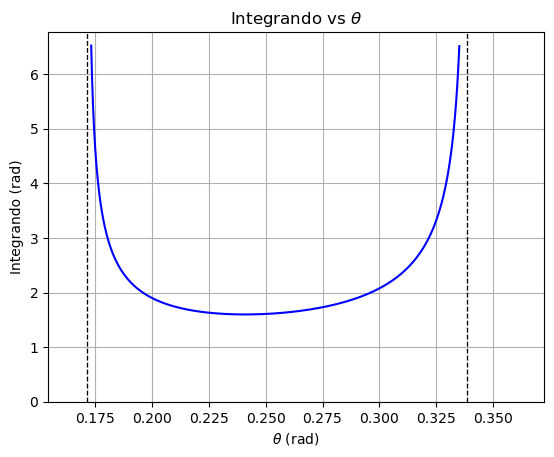

Asíntota diferente de theta0: 0.3384156352987808 rad
Ángulo extremo diferente de theta0 calculado: 0.3230700757716342 rad
Porcentaje de error: 4.749916714042497 %
Período teórico 2: 0.41870613595098 s
El error en la integración numérica fue: 6.674583108434717e-11
Período experimental: 0.428125085625 s
Porcetaje de error 1: 3.068660493687867%
Porcetaje de error 2: 2.200046199177917%


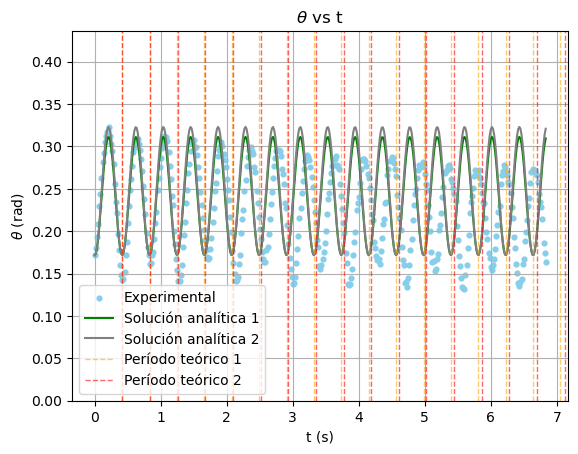

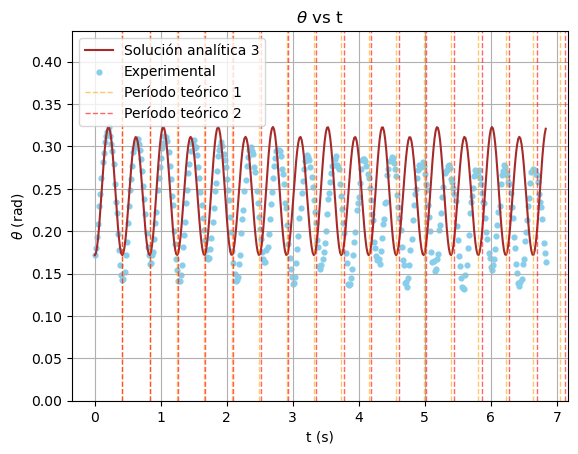

R2 de theta1: 0.6583295484294085
R2 de theta2: 0.6091501589361263
R2 de theta3: 0.6483892064744248


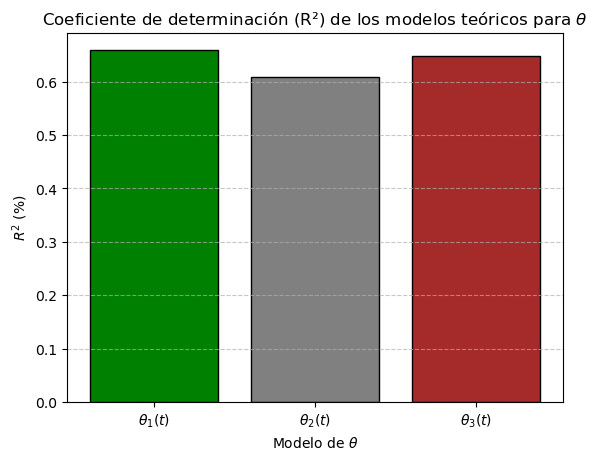

Ángulo pequeño: False
Variación pequeña: 0.8809, False


In [11]:
df=pd.read_excel(file_path1)

omega=2*(g/l)**(1/2)
i=0
#======================================Determinación de u0 e inserción a la base de datos df======================================
df.loc[0, 'ω']=determine_u0(df['ω'])[i]
print(f"Rapidez angular azimutal inicial: {float(df.loc[0, 'ω'])} rad/s")
print(f"Sqrt(g/l * sec theta0)={np.sqrt(g/l*1/np.cos(float(df.loc[0, 'theta'])))} rad/s")

#==========================================================Solución analítica 1==========================================================
vec1=aSol1(df, omega, i)
A=vec1[0]
B=vec1[1]
df['theta1']=vec1[2]


#==========================================================Solución analítica 2==========================================================
vec2=aSol2(df, omega, i)
C=vec2[0]
D=vec2[1]
df['theta2']=vec2[2]

# Período
tau2=period(df)

#Graficación
graph1(df, tau2)

# Solución analítica 3
aSol3(df, tau2, -C, D, -A, B)

r2_bargraph(df, True)

print("Ángulo pequeño: " + str(float(df['theta'].max())<=np.pi/15))

# Se usan parámetros de la solución analítica 2 porque incluye a los 2 ángulos extremos de la oscilación
# 2C = theta0-thetaf
# C+D = theta0
print("Variación pequeña: " + "{:.4g}".format(np.abs(2*C / (C+D))) + ", " + str(round(np.abs(2*C / (C+D)), 3)<=0.40))

$\phi(t)$

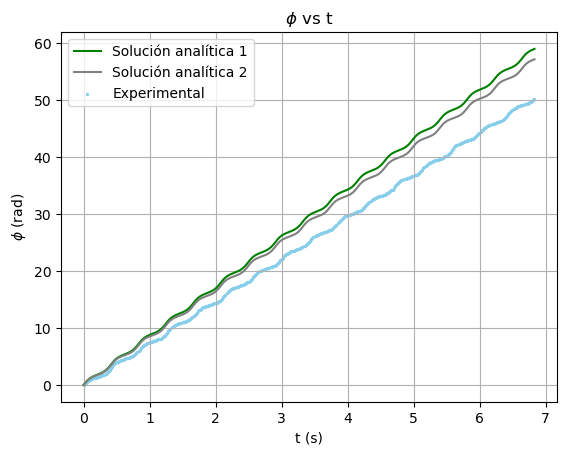

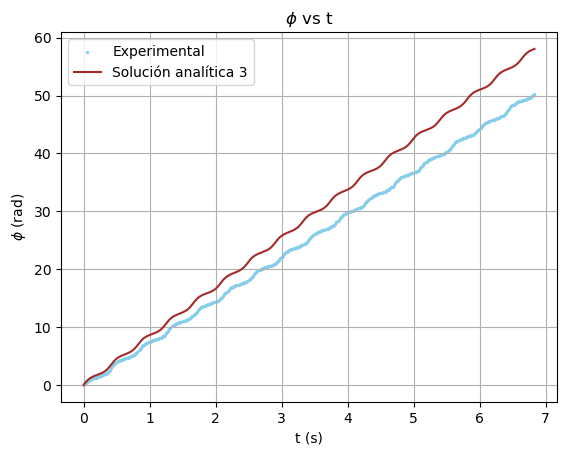

In [12]:
theta0=df['theta'].iloc[0]
u0=df['ω'].iloc[0]

#==========================================================Solución analítica 1==========================================================
df['phi1']=phiSol1(df)

#==========================================================Solución analítica 2==========================================================
df['phi2']=phiSol2(df)

graph2(df)

#==========================================================Solución analítica 3==========================================================
df['phi3']=phiSol3(df)

graph3(df)

Error de modelos teóricos

MAPE del primer modelo: 29.23062147548877
MAPE del segundo modelo: 30.91738592791276
MAE del primer modelo: 0.057770944809997664
MAE del segundo modelo: 0.06069424486152224
MdAPE del primer modelo: 22.120605598850734
MdAPE del segundo modelo: 22.53699103495598
MdAE del primer modelo: 0.049872490719517604
MdAE del segundo modelo: 0.052469752530809155
MAPE del tercer modelo: 29.946107506292506
MAE del tercer modelo: 0.05902563350723375
MdAPE del tercer modelo: 22.172952841769707
MdAE del tercer modelo: 0.05013306818740687


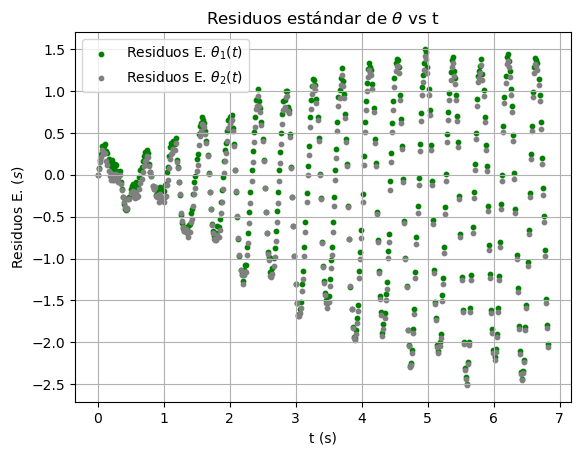

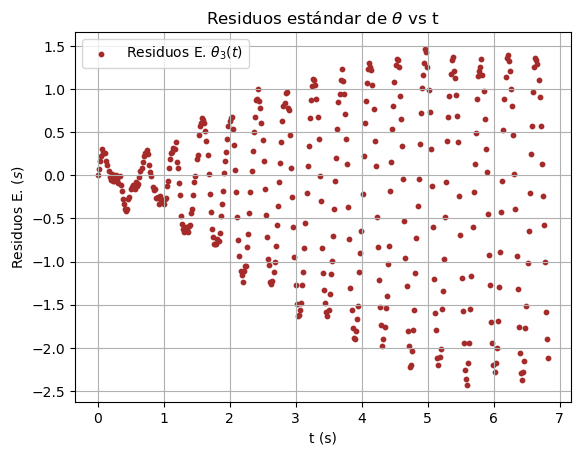

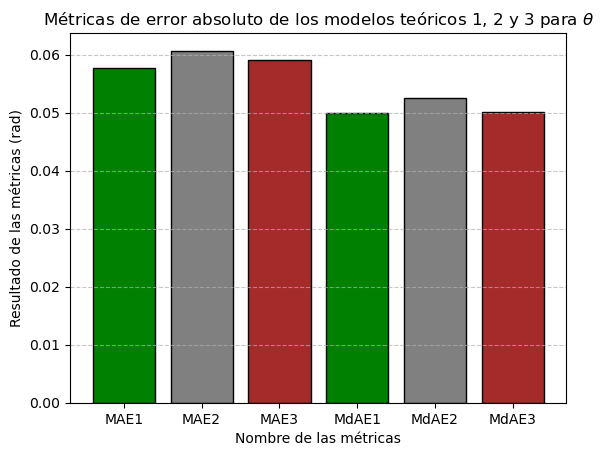

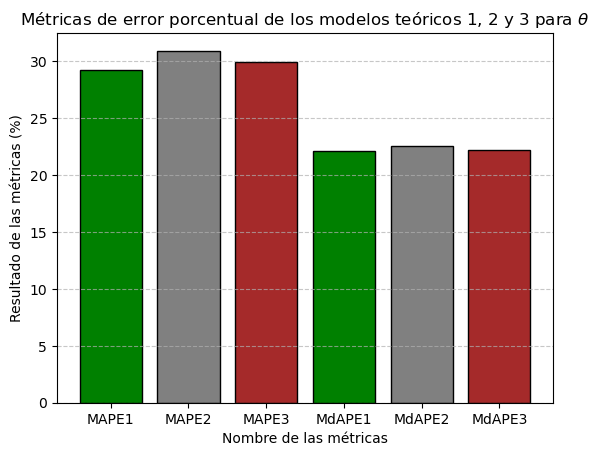

MAPE del primer modelo: 18.215448981393457
MAPE del segundo modelo: 14.619188738401709
MAE del primer modelo: 4.305425742021769
MAE del segundo modelo: 3.3954887841849875
MdAPE del primer modelo: 17.417756646148252
MdAPE del segundo modelo: 13.854679359231186
MdAE del primer modelo: 4.255757913680828
MdAE del segundo modelo: 3.3640337656758454
MAPE del tercer modelo: 16.159895677877433
MAE del tercer modelo: 3.8233433583755256
MdAPE del tercer modelo: 15.412815668778087
MdAE del tercer modelo: 3.767166926813484


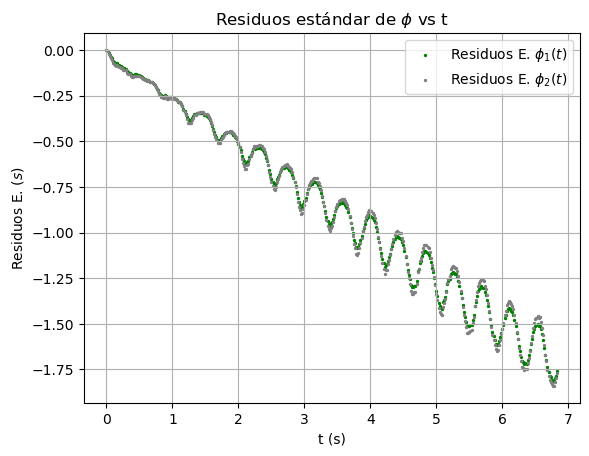

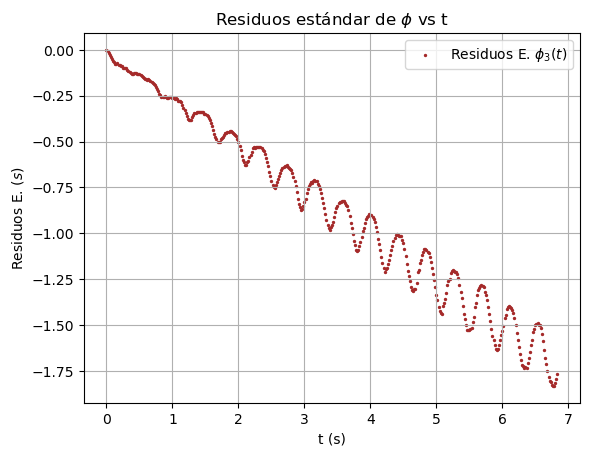

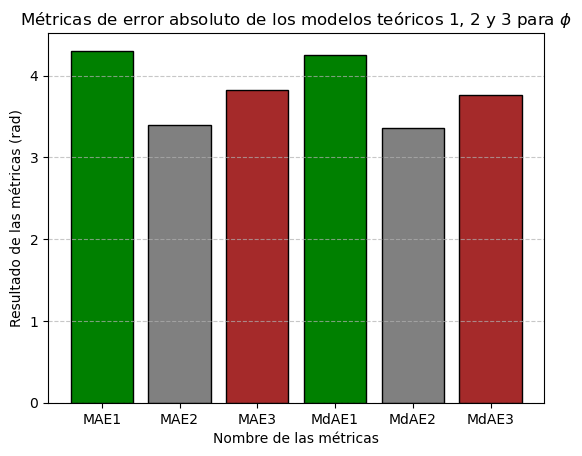

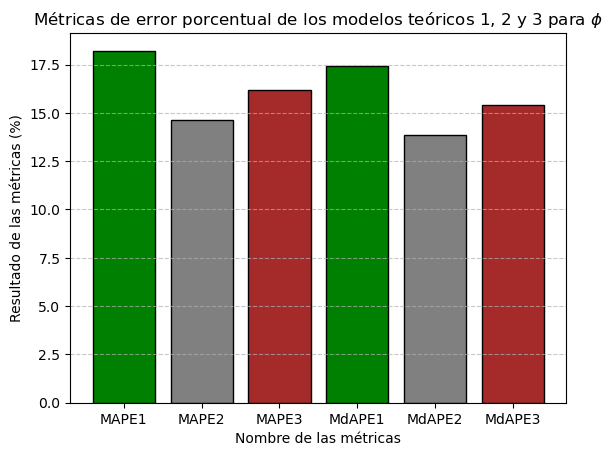

In [13]:
# Error
flag = True
errortheta(df, flag)
errorphi(df, flag)

**Machine Learning**

In [14]:
# Cálculo de residuos
df['resids1']=residuals1(df)
df['resids2']=residuals2(df)
if flag: df['resids3']=residuals3(df)

*Random Forest*

MAPE: 136.51355217691358, MdAPE: 52.493931428367645
R2: 0.6766229236138299


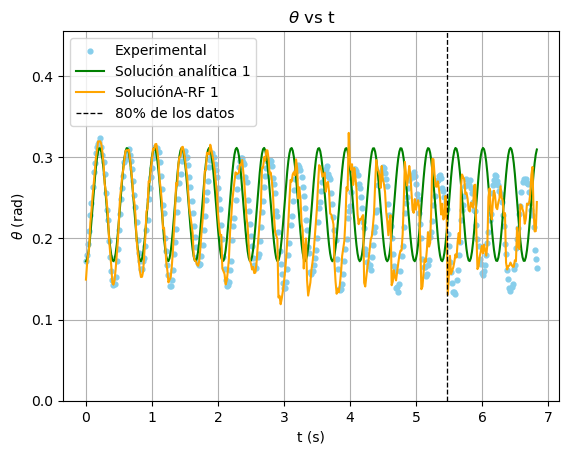

MAPE: 1064547994822076.5, MdAPE: 57.35945058607839
R2: 0.6343276530211798


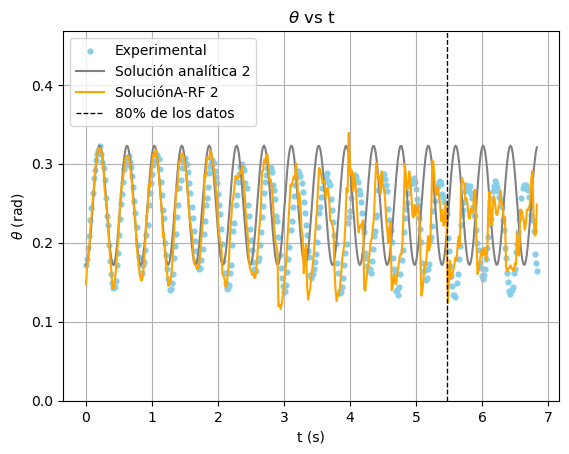

MAPE: 129.85835649159944, MdAPE: 58.27144927823929
R2: 0.6570687061572009


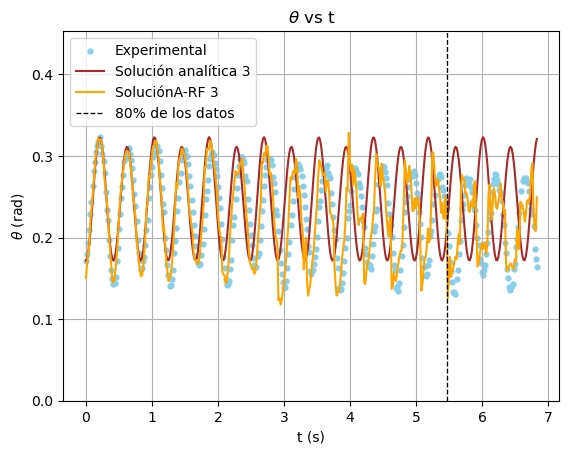

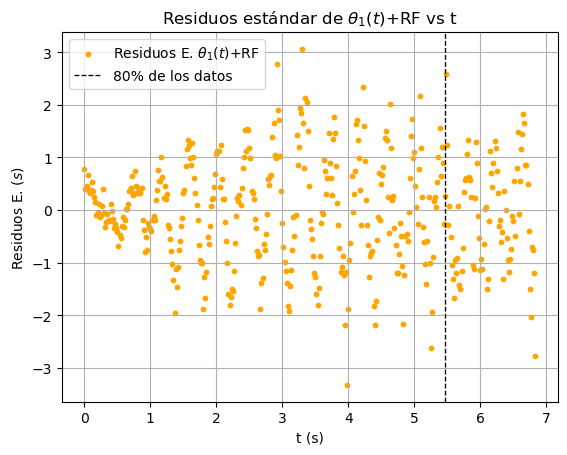

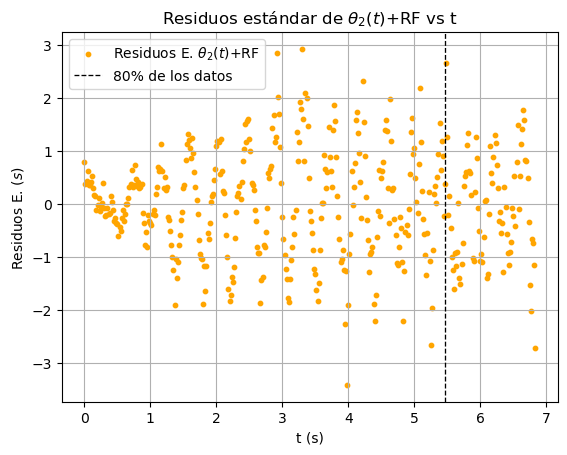

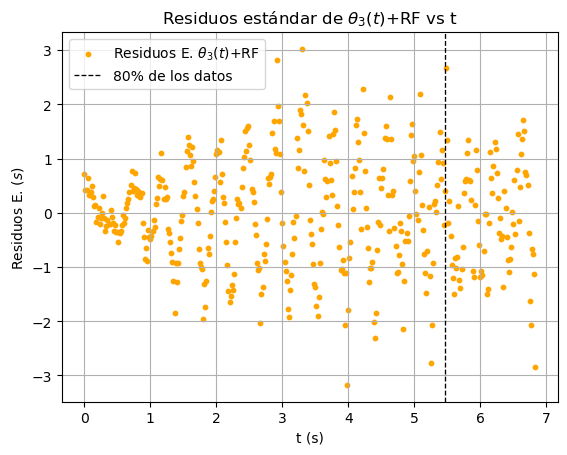

In [15]:
randomForestTotal(df, flag)
residsRF(df, flag)

C:\Users\jmarr\AppData\Local\Temp\ipykernel_876\3292867183.py:34: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  values.append(simps(u0*theta0**2/(df['theta1RF'].iloc[0:i])**2, df['t'].iloc[0:i]))


MdAPE: 34.7852820091198


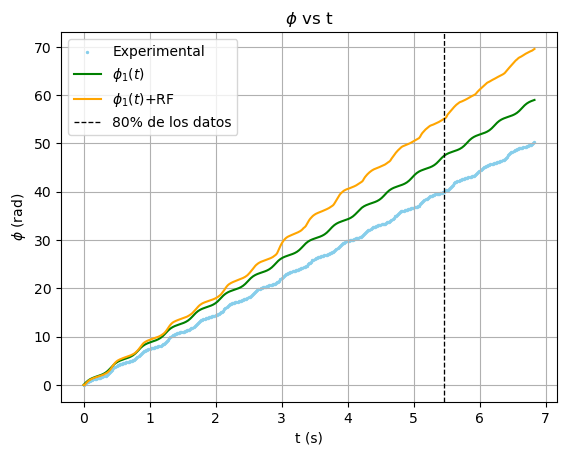

C:\Users\jmarr\AppData\Local\Temp\ipykernel_876\3292867183.py:55: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  values.append(simps(u0*theta0**2/(df['theta2RF'].iloc[0:i])**2, df['t'].iloc[0:i]))


MdAPE: 36.09878576773228


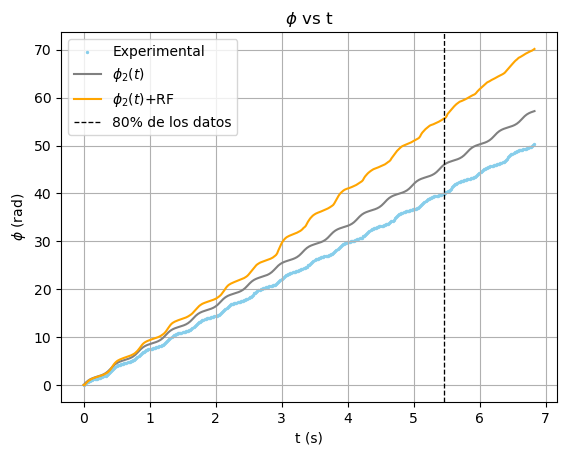

C:\Users\jmarr\AppData\Local\Temp\ipykernel_876\3292867183.py:76: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  values.append(simps(u0*theta0**2/(df['theta3RF'].iloc[0:i])**2, df['t'].iloc[0:i]))


MdAPE: 35.51884609259845


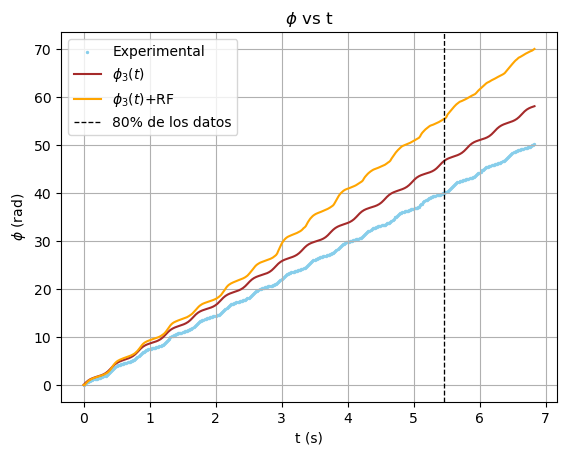

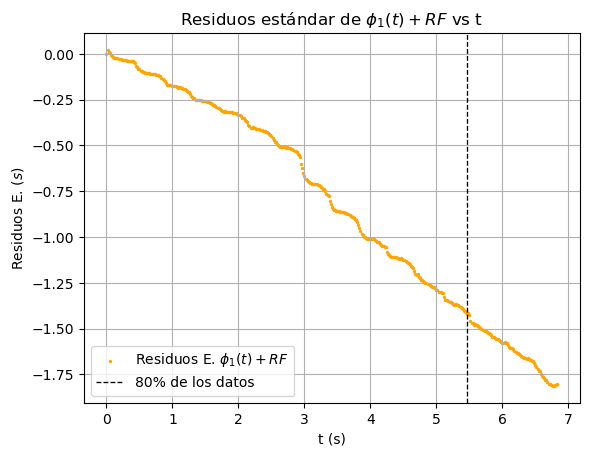

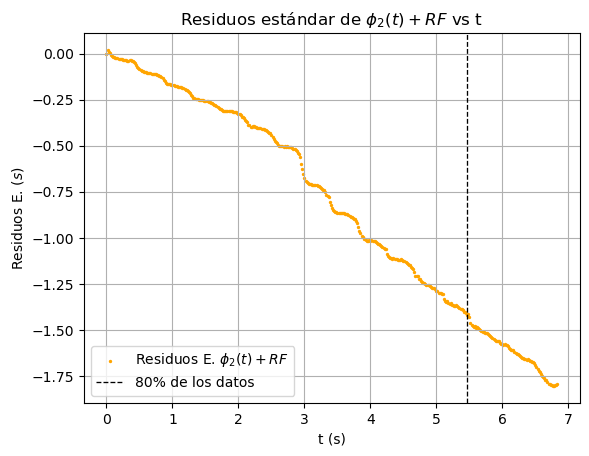

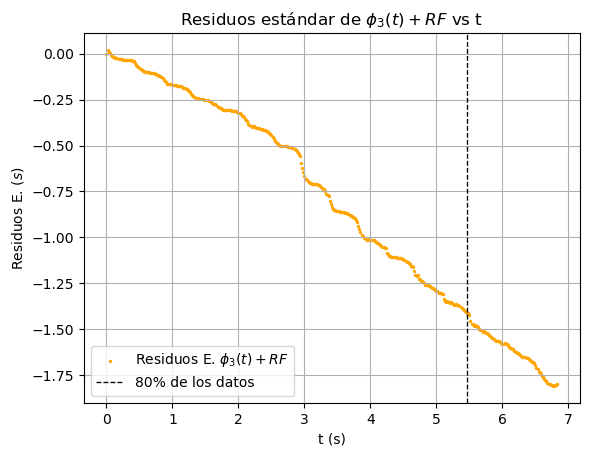

In [16]:
newPhi(df, "RF", flag, u0, theta0)

*XGBoost*

MAPE: 97.69733042206644, MdAPE: 56.96419891418287
R2: 0.7795837664326667


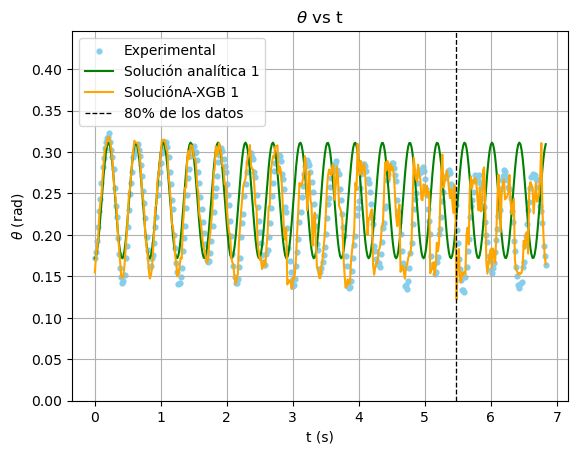

MAPE: 860077307780737.0, MdAPE: 56.76939056919955
R2: 0.7532775854703754


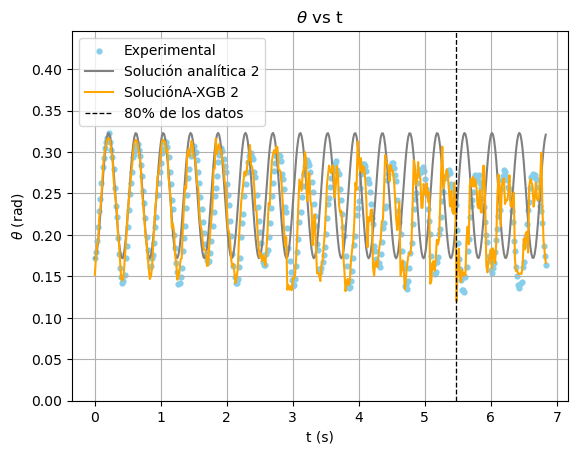

MAPE: 99.0081873126616, MdAPE: 52.51316148557661
R2: 0.7680818212402987


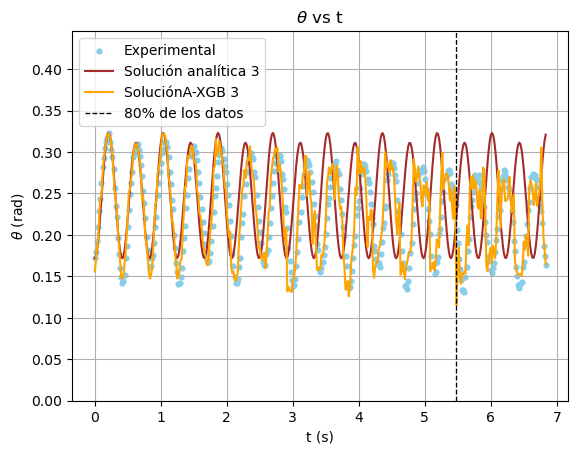

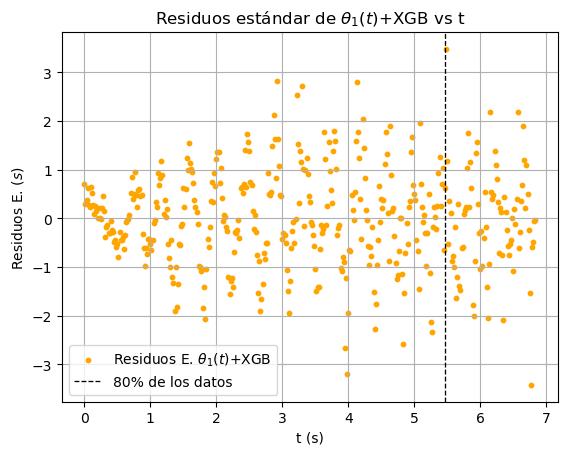

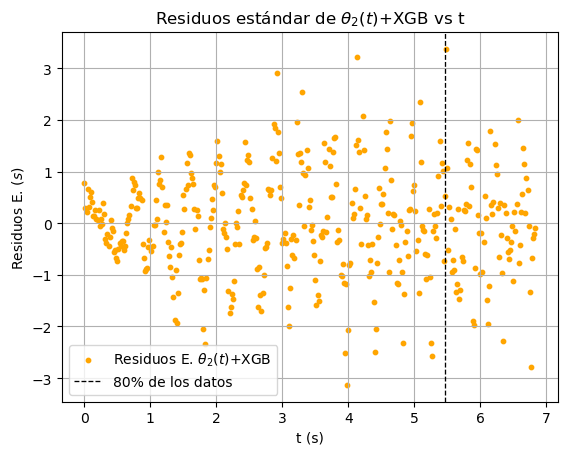

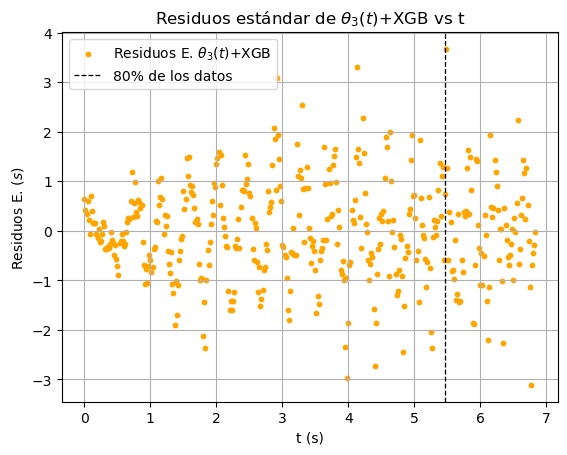

In [17]:
XGBoostTotal(df, flag)
residsXGB(df, flag)

C:\Users\jmarr\AppData\Local\Temp\ipykernel_876\3292867183.py:133: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  values.append(simps(u0*theta0**2/(df['theta1XGB'].iloc[0:i])**2, df['t'].iloc[0:i]))


MdAPE: 31.77783246625987


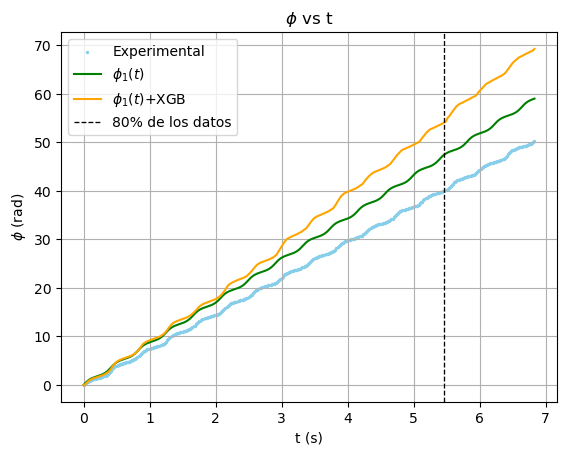

C:\Users\jmarr\AppData\Local\Temp\ipykernel_876\3292867183.py:154: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  values.append(simps(u0*theta0**2/(df['theta2XGB'].iloc[0:i])**2, df['t'].iloc[0:i]))


MdAPE: 32.156490770565675


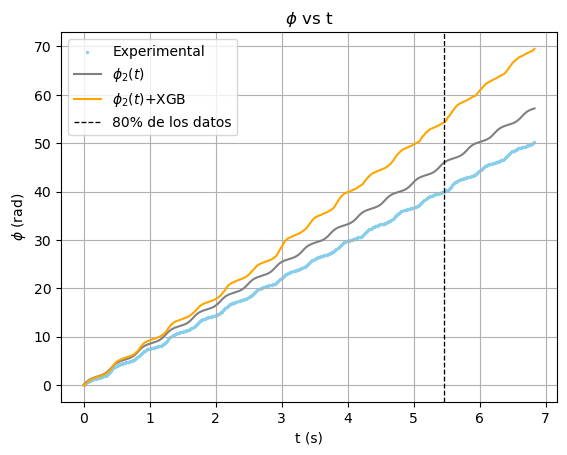

C:\Users\jmarr\AppData\Local\Temp\ipykernel_876\3292867183.py:175: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  values.append(simps(u0*theta0**2/(df['theta3XGB'].iloc[0:i])**2, df['t'].iloc[0:i]))


MdAPE: 32.16581869501935


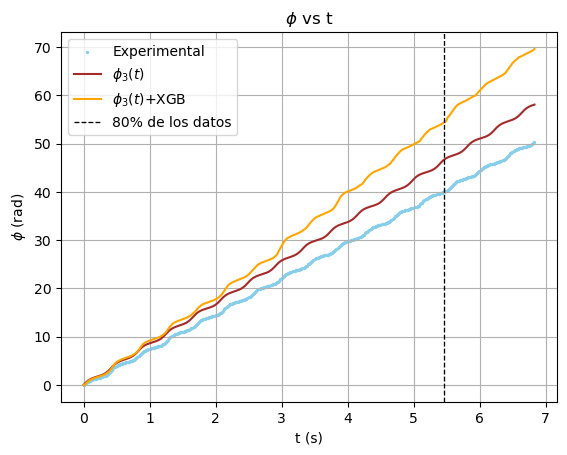

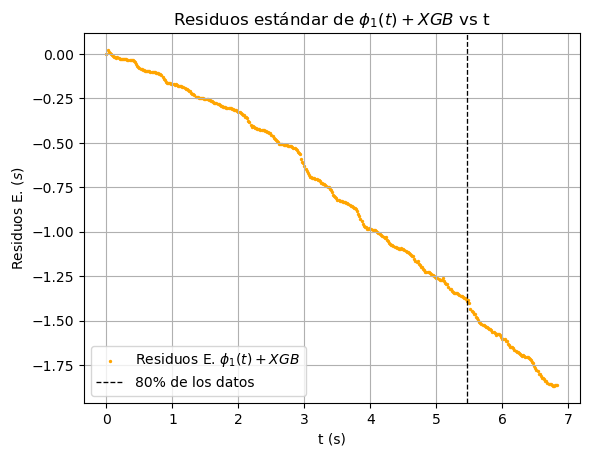

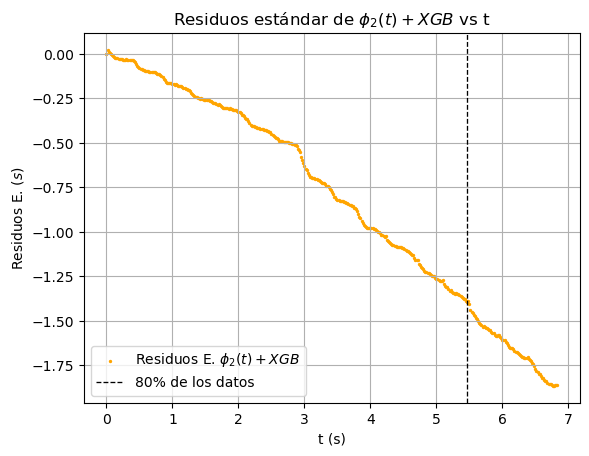

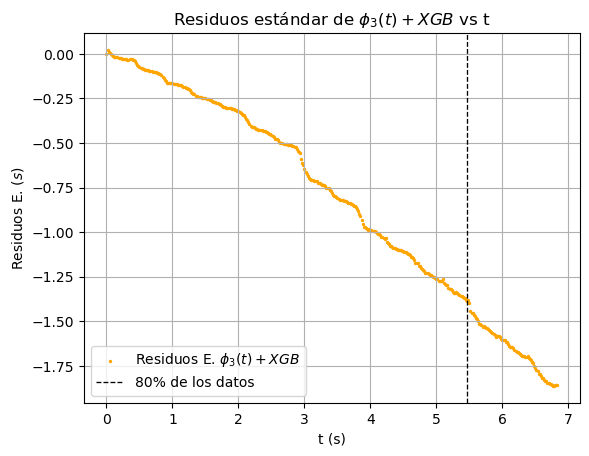

In [18]:
newPhi(df, "XGB", flag, u0, theta0)

*Neural Networks*

Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 1.5453 - mae: 0.9847 - val_loss: 0.7772 - val_mae: 0.7175
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2304 - mae: 0.8847 - val_loss: 0.7942 - val_mae: 0.7097
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0972 - mae: 0.8369 - val_loss: 0.8341 - val_mae: 0.7088
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8654 - mae: 0.7810 - val_loss: 0.8435 - val_mae: 0.7177
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.0309 - mae: 0.7727 - val_loss: 0.8629 - val_mae: 0.7288
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7264 - mae: 0.6876 - val_loss: 0.8621 - val_mae: 0.7272
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6234 - mae: 0.6520 - val_loss: 0.8772 - val_mae: 0.7279
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6899 - mae: 0.6626 - val_loss: 0.8569 - val_mae: 0.7195
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5947 - mae: 

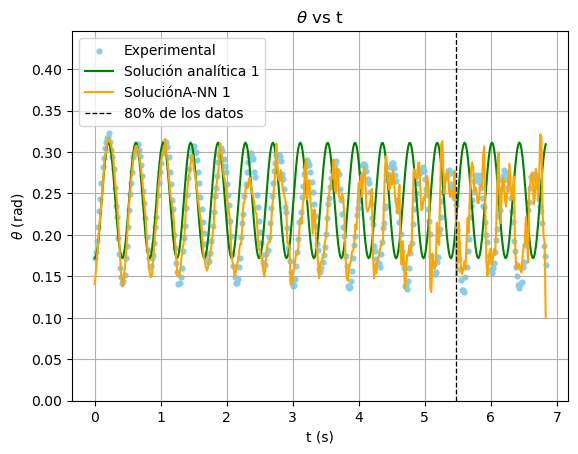

MAPE: 1656.1565920678088, MdAPE: 25.676794017863358
R2: 0.8282532264227799


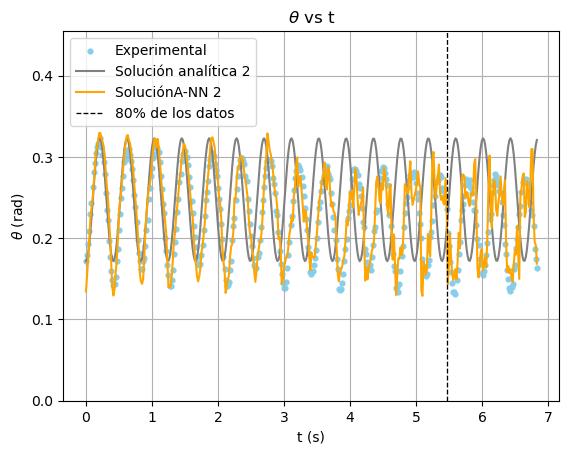

MAPE: 251.64018694207203, MdAPE: 26.358895059133623
R2: 0.7730900372012854


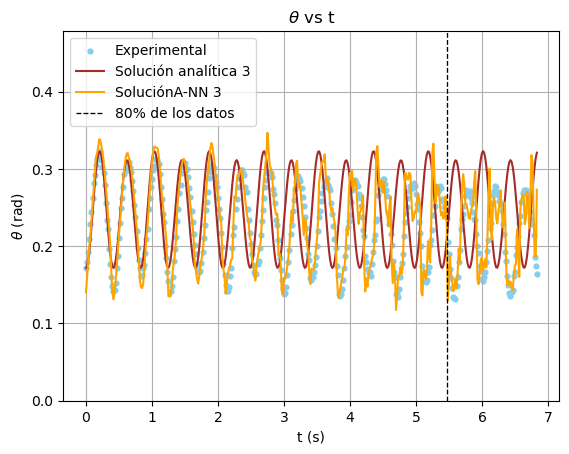

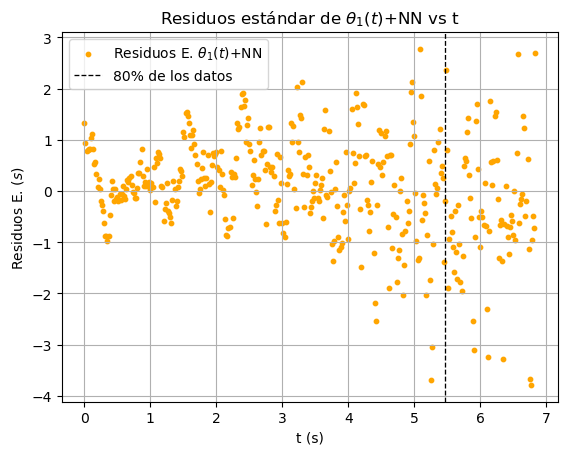

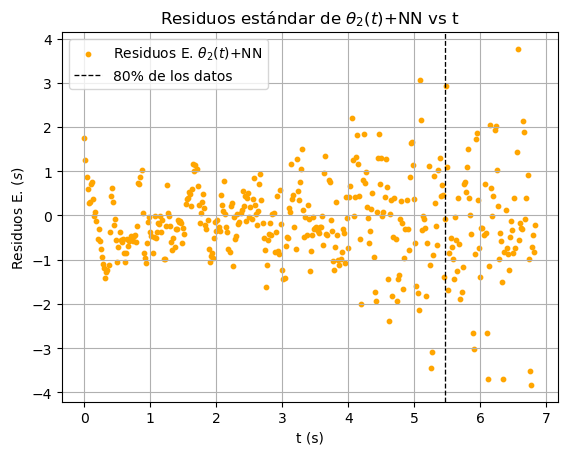

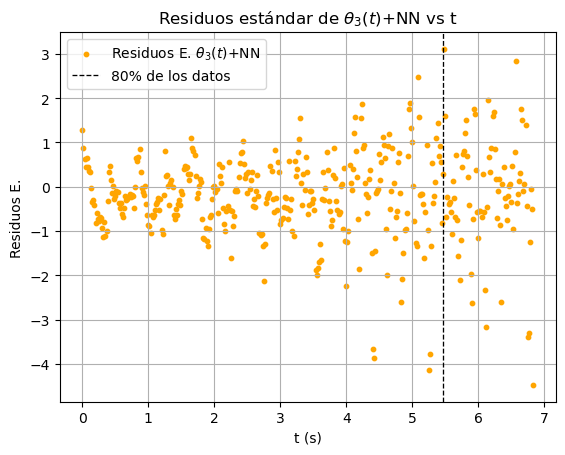

In [19]:
nnTotal(df, flag)
residsNN(df, flag)

C:\Users\jmarr\AppData\Local\Temp\ipykernel_876\3292867183.py:231: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  values.append(simps(u0*theta0**2/(df['theta1NN'].iloc[0:i])**2, df['t'].iloc[0:i]))


MdAPE: 35.456728934868686


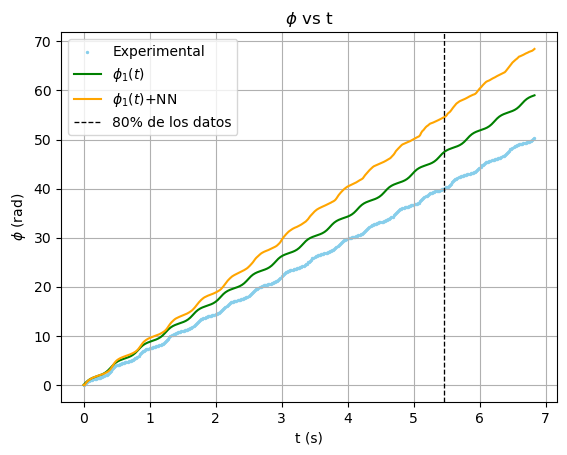

C:\Users\jmarr\AppData\Local\Temp\ipykernel_876\3292867183.py:252: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  values.append(simps(u0*theta0**2/(df['theta2NN'].iloc[0:i])**2, df['t'].iloc[0:i]))


MdAPE: 29.192505924952687


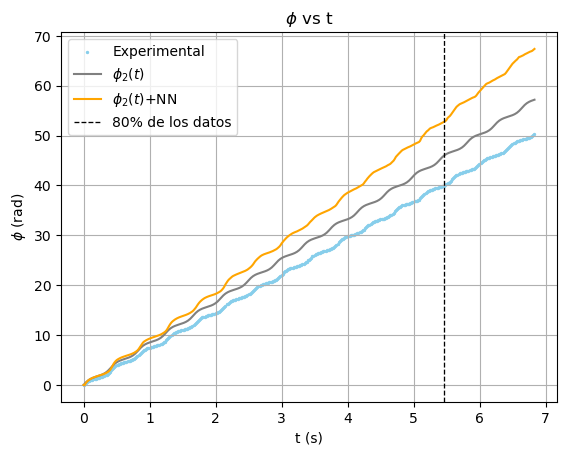

C:\Users\jmarr\AppData\Local\Temp\ipykernel_876\3292867183.py:273: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  values.append(simps(u0*theta0**2/(df['theta3NN'].iloc[0:i])**2, df['t'].iloc[0:i]))


MdAPE: 28.60470460447091


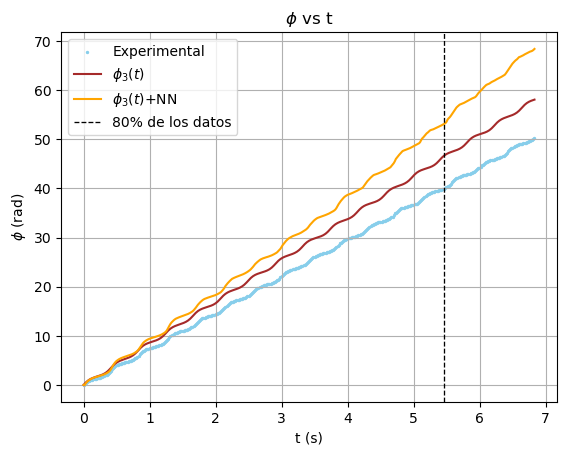

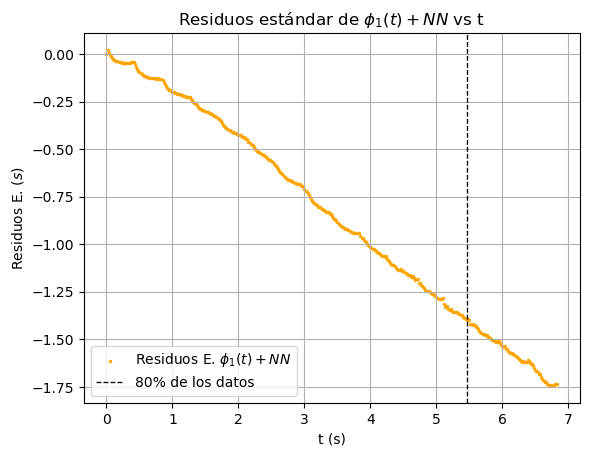

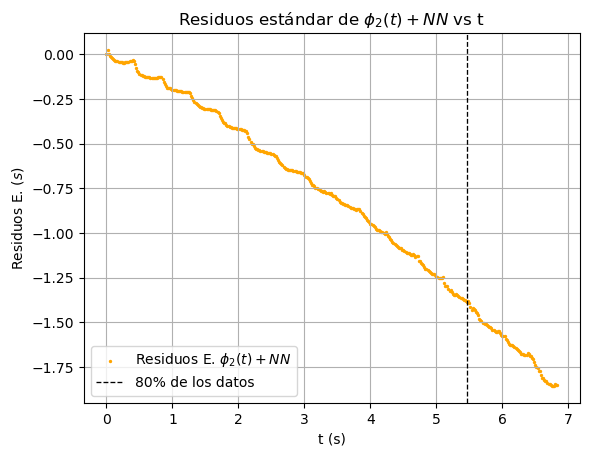

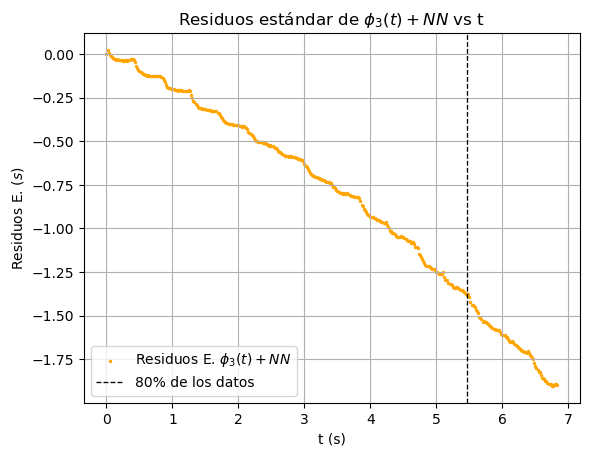

In [20]:
newPhi(df, "NN", flag, u0, theta0)

*2*

In [21]:
file_path2 = r"D:\Académico\Universidad del Valle de Guatemala\Tesis de Licenciatura\Dataframes\Sistema 1\S1_R2_2.xlsx"
#process_excel(file_path2, file_path2)

In [22]:
#create_theta(l, file_path2, file_path2)

$\theta(t)$

Rapidez angular azimutal inicial: 17.427989999999998 rad/s
Sqrt(g/l * sec theta0)=7.656810636644806 rad/s
Período teórico 1: 0.4149873802588583 s


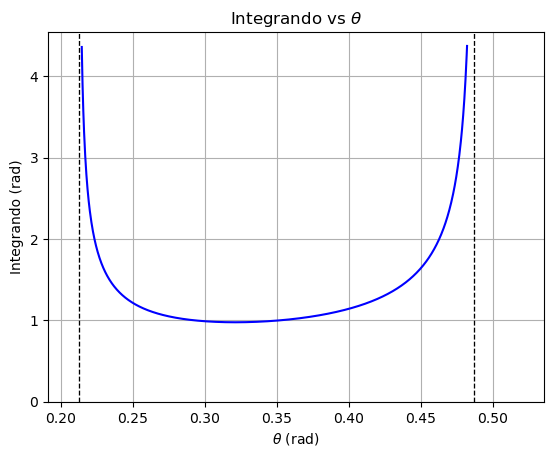

Asíntota diferente de theta0: 0.48708536399795505 rad
Ángulo extremo diferente de theta0 calculado: 0.538341803276168 rad
Porcentaje de error: 9.52117018709738 %
Período teórico 2: 0.4222714601791476 s
El error en la integración numérica fue: 6.908362770730037e-11
Período experimental: 0.4319444444444427 s
Porcetaje de error 1: 3.9257511940902954%
Porcetaje de error 2: 2.239404717367367%


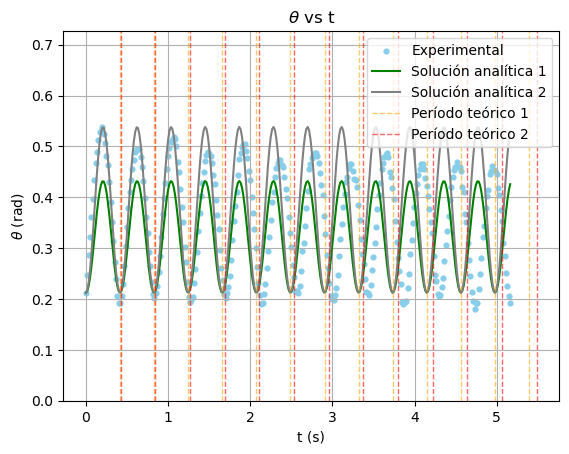

R2 de theta1: 0.6111265450752017
R2 de theta2: 0.8474935937675644


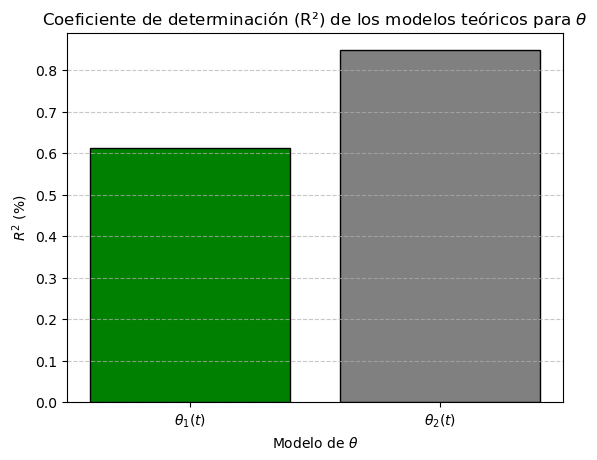

Ángulo pequeño: False
Variación pequeña: 1.535, False


In [23]:
df=pd.read_excel(file_path2)

omega=2*(g/l)**(1/2)
i=0
#======================================Determinación de u0 e inserción a la base de datos df======================================
df.loc[0, 'ω']=determine_u0(df['ω'])[i]
print(f"Rapidez angular azimutal inicial: {float(df.loc[0, 'ω'])} rad/s")
print(f"Sqrt(g/l * sec theta0)={np.sqrt(g/l*1/np.cos(float(df.loc[0, 'theta'])))} rad/s")

#==========================================================Solución analítica 1==========================================================
vec1=aSol1(df, omega, i)
A=vec1[0]
B=vec1[1]
df['theta1']=vec1[2]


#==========================================================Solución analítica 2==========================================================
vec2=aSol2(df, omega, i)
C=vec2[0]
D=vec2[1]
df['theta2']=vec2[2]

# Período
tau2 = period(df)

#Graficación
graph1(df, tau2)

r2_bargraph(df, False)

print("Ángulo pequeño: " + str(float(df['theta'].max())<=np.pi/15))

# Se usan parámetros de la solución analítica 2 porque incluye a los 2 ángulos extremos de la oscilación
# 2C = theta0-thetaf
# C+D = theta0
print("Variación pequeña: " + "{:.4g}".format(np.abs(2*C / (C+D))) + ", " + str(round(np.abs(2*C / (C+D)), 3)<=0.40))

$\phi(t)$

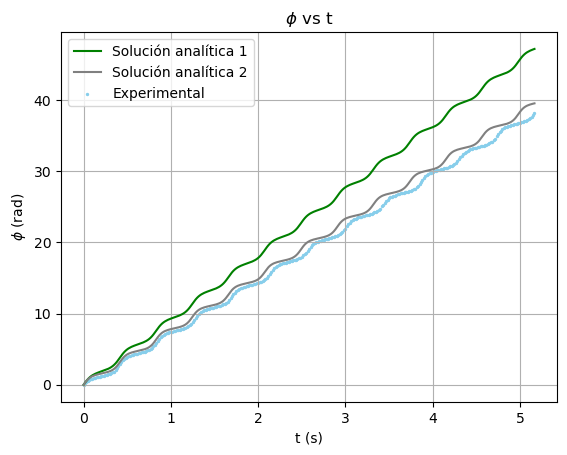

In [24]:
theta0=df['theta'].iloc[0]
u0=df['ω'].iloc[0]

#==========================================================Solución analítica 1==========================================================
df['phi1']=phiSol1(df)

#==========================================================Solución analítica 2==========================================================
df['phi2']=phiSol2(df)

graph2(df)

Error de modelos teóricos

MAPE del primer modelo: 29.698635576327014
MAPE del segundo modelo: 35.29079450821738
MAE del primer modelo: 0.09889236075726342
MAE del segundo modelo: 0.10700043489693772
MdAPE del primer modelo: 23.332786190091102
MdAPE del segundo modelo: 25.567935459373974
MdAE del primer modelo: 0.08947591710055297
MdAE del segundo modelo: 0.08745520078092117


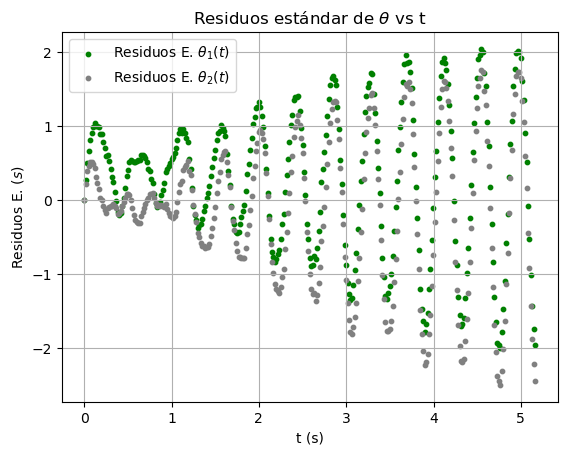

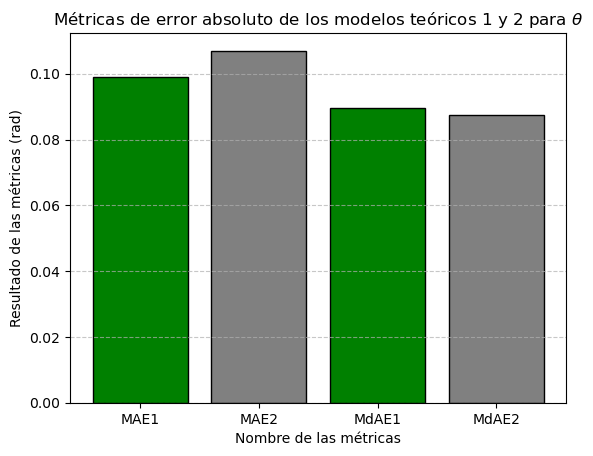

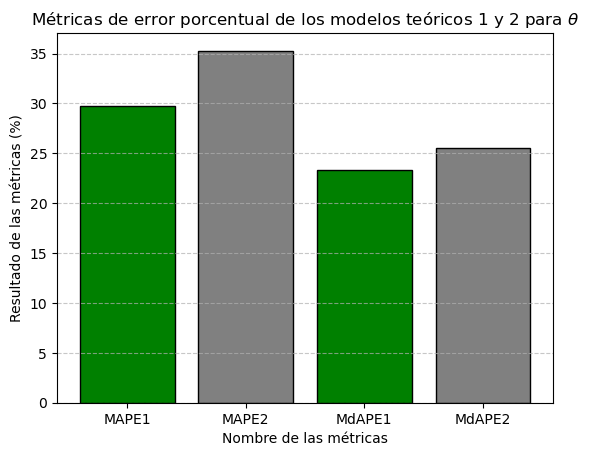

MAPE del primer modelo: 26.70448032214962
MAPE del segundo modelo: 6.485963680060657
MAE del primer modelo: 4.565886327340251
MAE del segundo modelo: 0.7435580866004534
MdAPE del primer modelo: 24.794175115885146
MdAPE del segundo modelo: 4.662017706748426
MdAE del primer modelo: 4.485204979918194
MdAE del segundo modelo: 0.5087287042074351


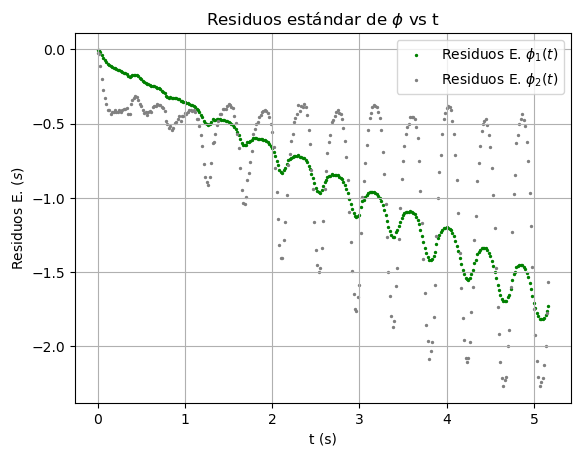

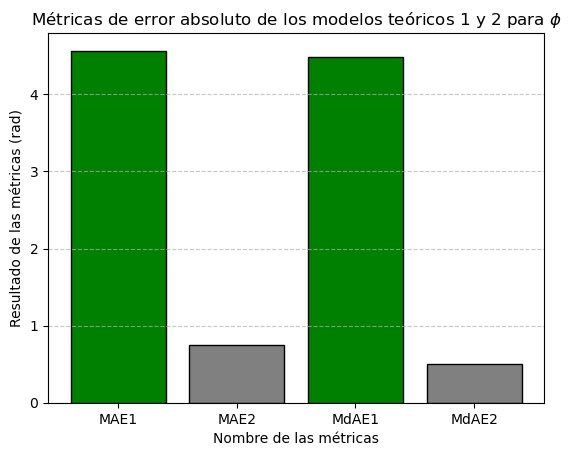

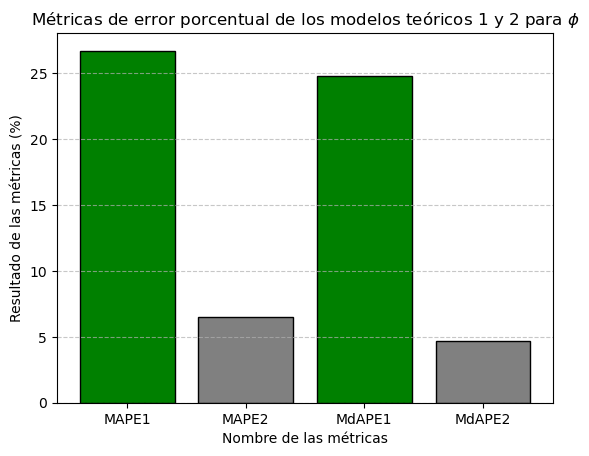

In [25]:
# Error
flag = False
errortheta(df, flag)
errorphi(df, flag)

**Machine Learning**

In [26]:
# Cálculo de residuos
df['resids1']=residuals1(df)
df['resids2']=residuals2(df)
if flag: df['resids3']=residuals3(df)

*Random Forest*

MAPE: 87.8615396639883, MdAPE: 35.22954335863532
R2: 0.8156417377190401


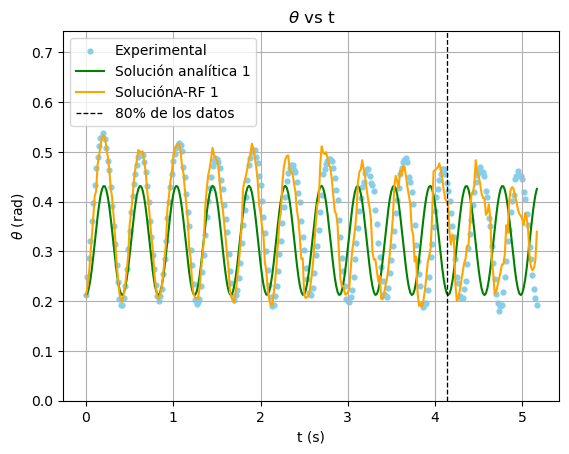

MAPE: 76.56142049651552, MdAPE: 57.983443351183695
R2: 0.6477112763790818


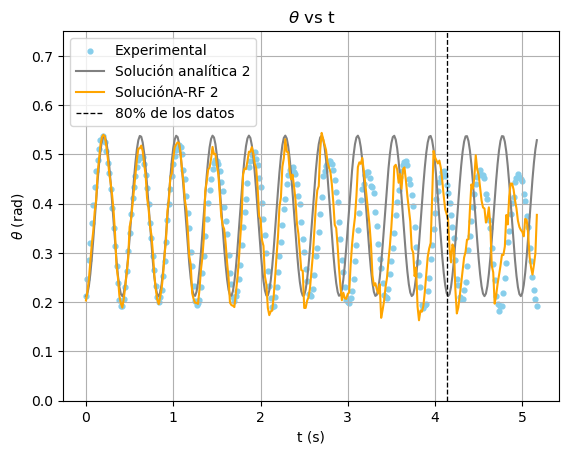

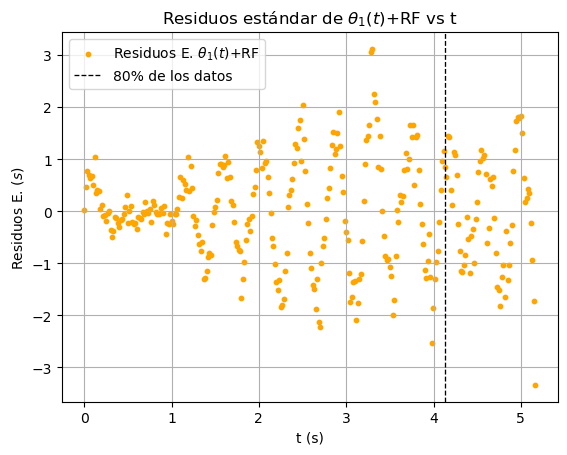

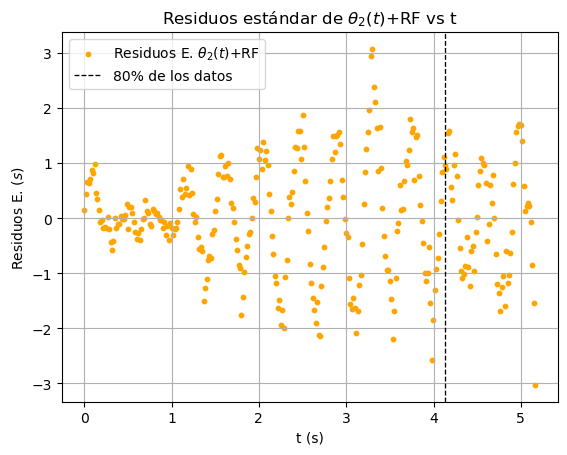

In [27]:
randomForestTotal(df, flag)
residsRF(df, flag)

C:\Users\jmarr\AppData\Local\Temp\ipykernel_876\3292867183.py:34: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  values.append(simps(u0*theta0**2/(df['theta1RF'].iloc[0:i])**2, df['t'].iloc[0:i]))


MdAPE: 8.263304967480204


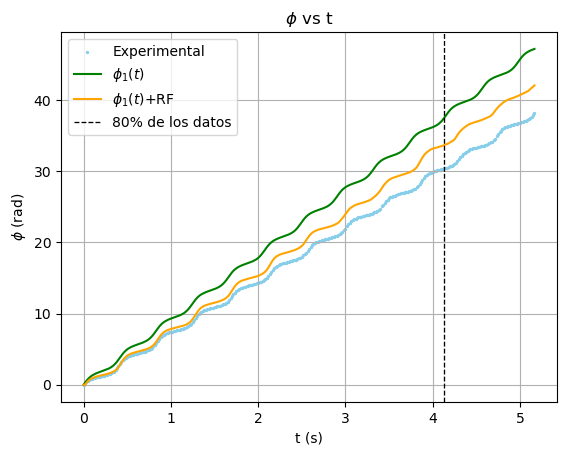

C:\Users\jmarr\AppData\Local\Temp\ipykernel_876\3292867183.py:55: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  values.append(simps(u0*theta0**2/(df['theta2RF'].iloc[0:i])**2, df['t'].iloc[0:i]))


MdAPE: 13.370397847609997


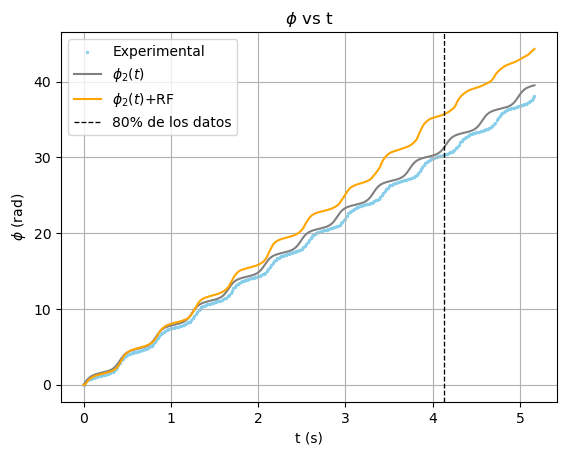

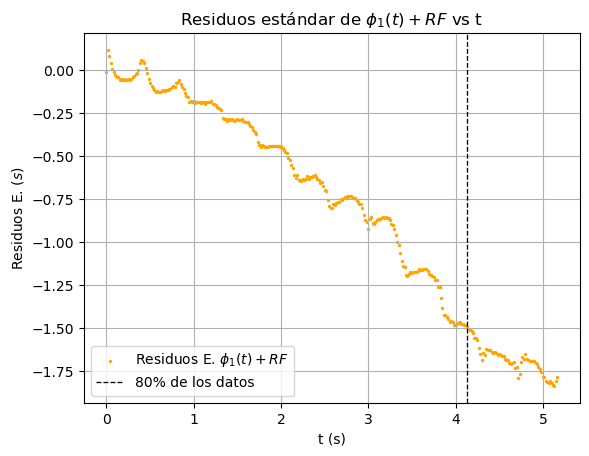

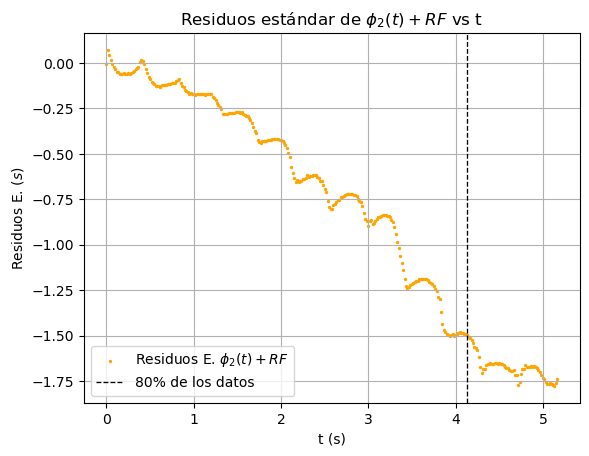

In [28]:
newPhi(df, "RF", flag, u0, theta0)

*XGBoost*

MAPE: 65.12093540572518, MdAPE: 19.5231497330753
R2: 0.9305319046098665


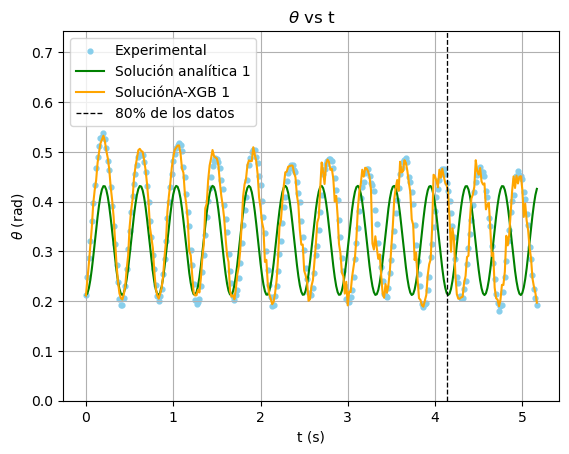

MAPE: 45.28494644346835, MdAPE: 31.04824473019046
R2: 0.8792843285152652


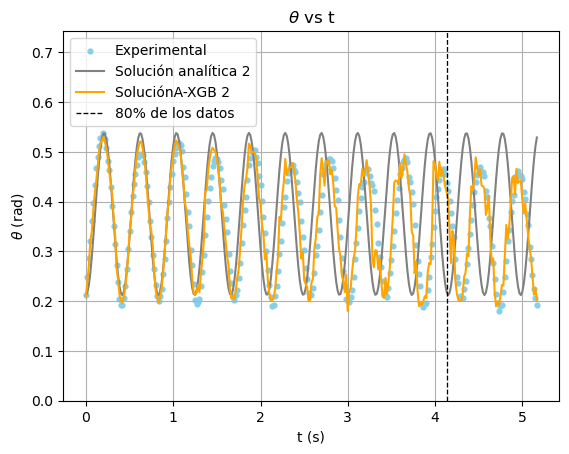

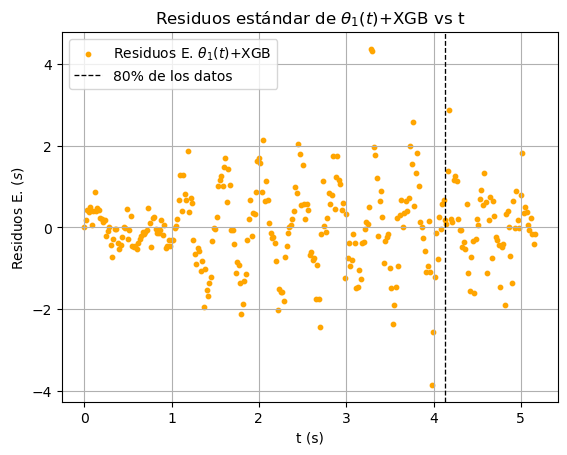

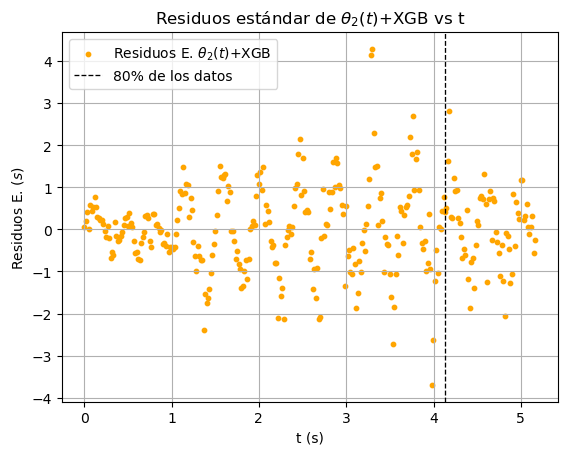

In [29]:
XGBoostTotal(df, flag)
residsXGB(df, flag)

C:\Users\jmarr\AppData\Local\Temp\ipykernel_876\3292867183.py:133: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  values.append(simps(u0*theta0**2/(df['theta1XGB'].iloc[0:i])**2, df['t'].iloc[0:i]))


MdAPE: 6.609024408197091


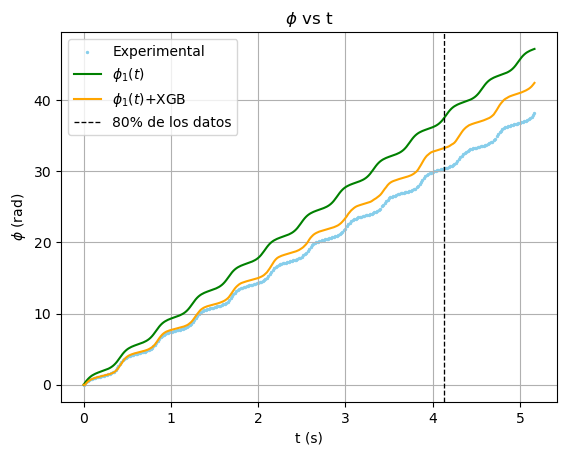

C:\Users\jmarr\AppData\Local\Temp\ipykernel_876\3292867183.py:154: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  values.append(simps(u0*theta0**2/(df['theta2XGB'].iloc[0:i])**2, df['t'].iloc[0:i]))


MdAPE: 6.680042132570831


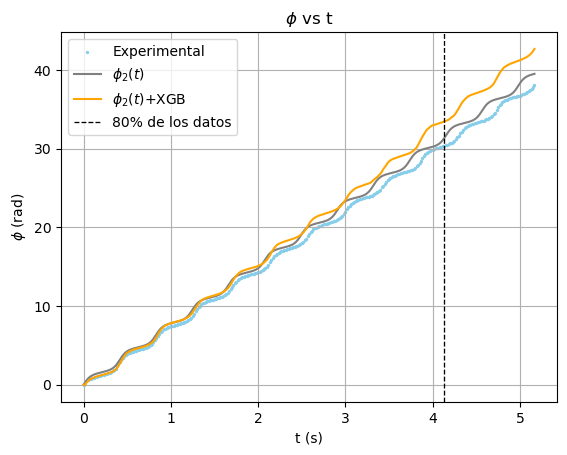

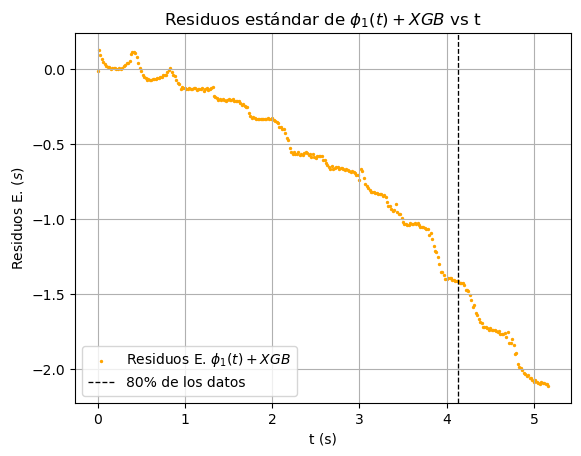

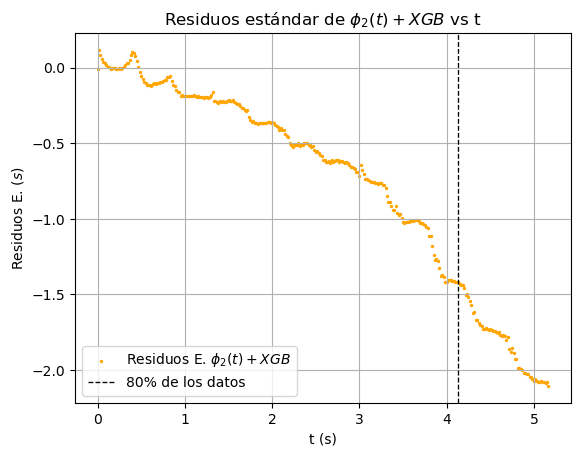

In [30]:
newPhi(df, "XGB", flag, u0, theta0)


*Neural Networks*

Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - loss: 2.2917 - mae: 1.1716 - val_loss: 0.8776 - val_mae: 0.7251
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.1417 - mae: 0.8511 - val_loss: 0.8659 - val_mae: 0.7129
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9218 - mae: 0.7672 - val_loss: 0.8512 - val_mae: 0.7054
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.0153 - mae: 0.8000 - val_loss: 0.8383 - val_mae: 0.7009
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8585 - mae: 0.7149 - val_loss: 0.8224 - val_mae: 0.6962
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6817 - mae: 0.6835 - val_loss: 0.8083 - val_mae: 0.6922
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6917 - mae: 0.6507 - val_loss: 0.7900 - val_mae: 0.6831
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7034 - mae: 0.6513 - val_loss: 0.7667 - val_mae: 0.6716
Epoch 9/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7585 - mae:

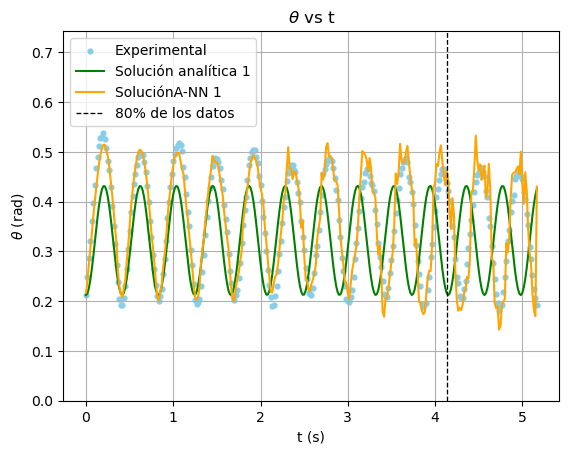

MAPE: 178.8843783398162, MdAPE: 23.487576824038406
R2: 0.8822243777002287


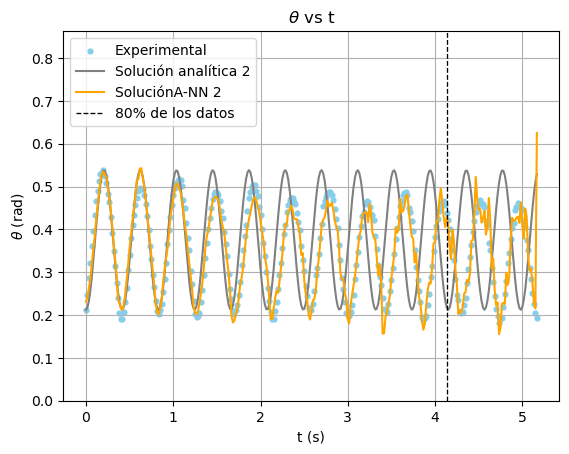

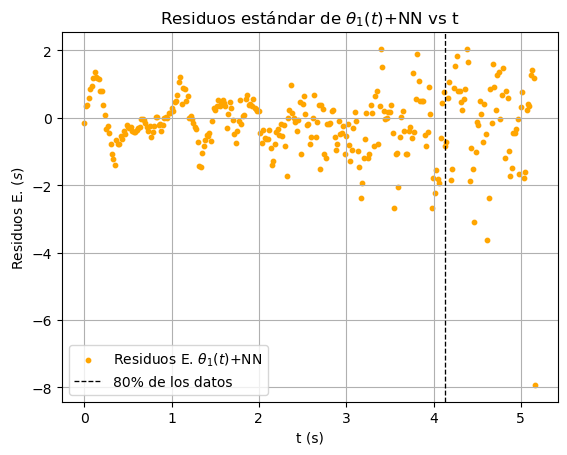

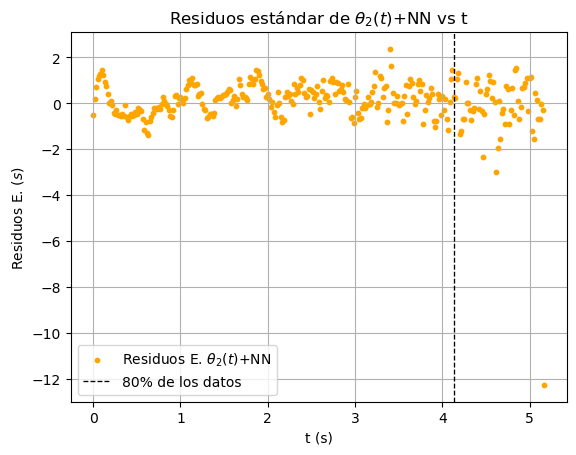

In [31]:
nnTotal(df, flag)
residsNN(df, flag)

C:\Users\jmarr\AppData\Local\Temp\ipykernel_876\3292867183.py:231: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  values.append(simps(u0*theta0**2/(df['theta1NN'].iloc[0:i])**2, df['t'].iloc[0:i]))


MdAPE: 2.1123175408028394


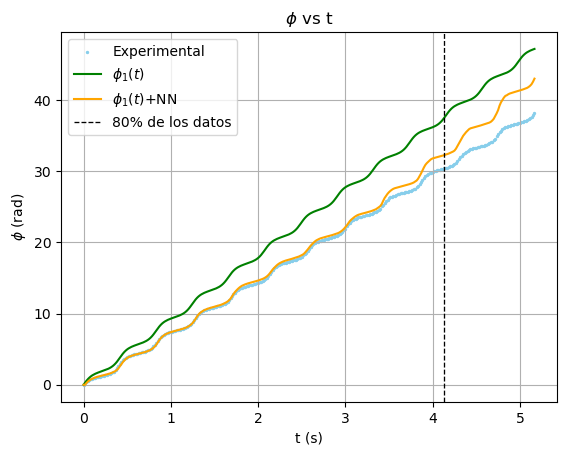

C:\Users\jmarr\AppData\Local\Temp\ipykernel_876\3292867183.py:252: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  values.append(simps(u0*theta0**2/(df['theta2NN'].iloc[0:i])**2, df['t'].iloc[0:i]))


MdAPE: 8.729615734130867


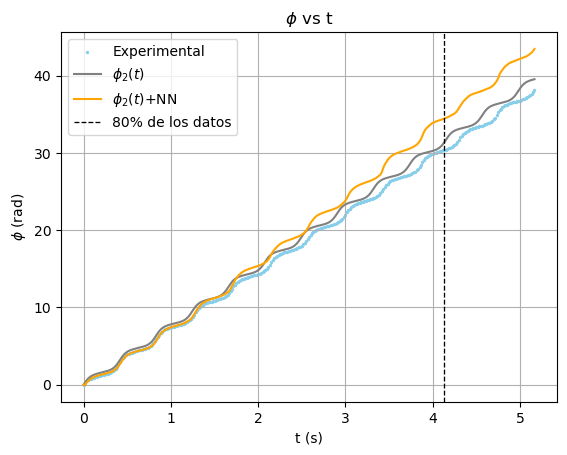

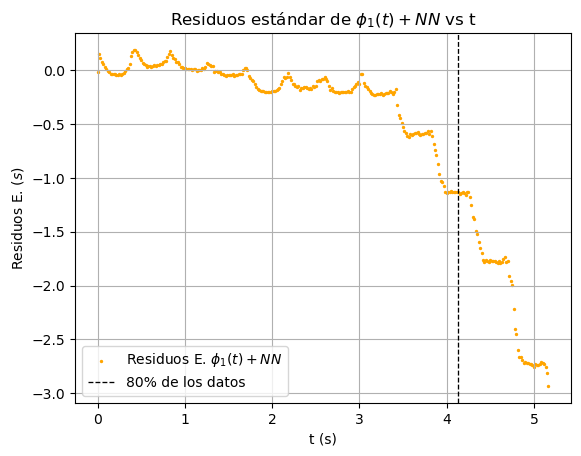

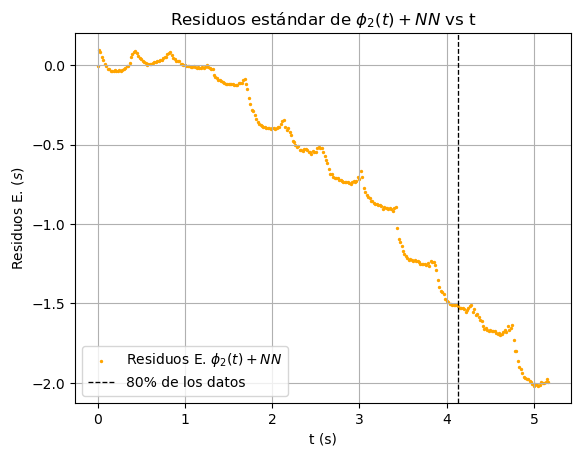

In [32]:
newPhi(df, "NN", flag, u0, theta0)

*3*

*Candidato a solución analítica 3*

In [33]:
file_path3 = r"D:\Académico\Universidad del Valle de Guatemala\Tesis de Licenciatura\Dataframes\Sistema 1\S1_R2_3.xlsx"
#process_excel(file_path3, file_path3)

In [34]:
#create_theta(l, file_path3, file_path3)

$\theta(t)$

Rapidez angular azimutal inicial: 4.219507500000001 rad/s
Sqrt(g/l * sec theta0)=7.657386319321101 rad/s
Período teórico 1: 0.4149873802588583 s


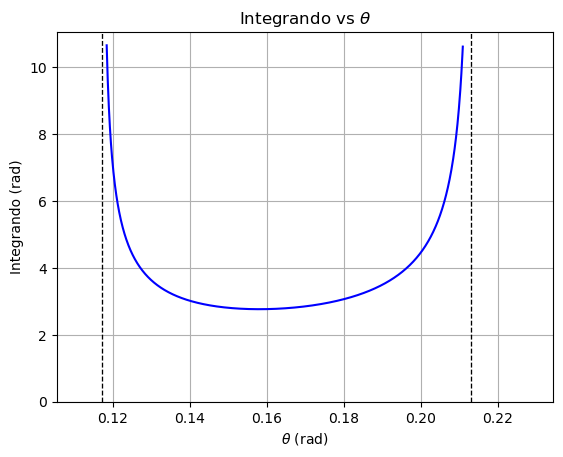

Asíntota diferente de theta0: 0.11724501632334704 rad
Ángulo extremo diferente de theta0 calculado: 0.11721059286576041 rad
Porcentaje de error: 0.02936889639834149 %
Período teórico 2: 0.416517720594676 s
El error en la integración numérica fue: 5.696465521509708e-11
Período experimental: 0.43194453083333345 s
Porcetaje de error 1: 3.925770408936631%
Porcetaje de error 2: 3.571479469573352%


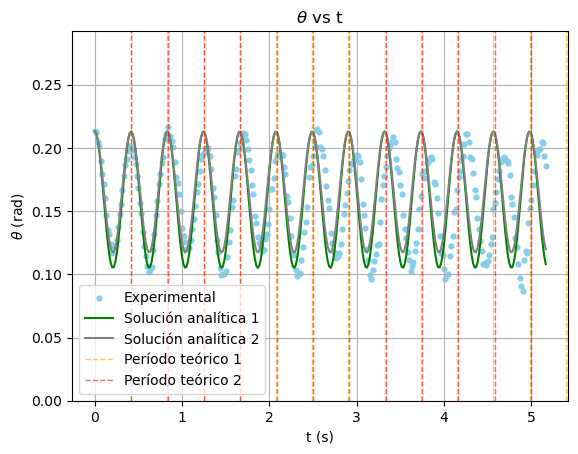

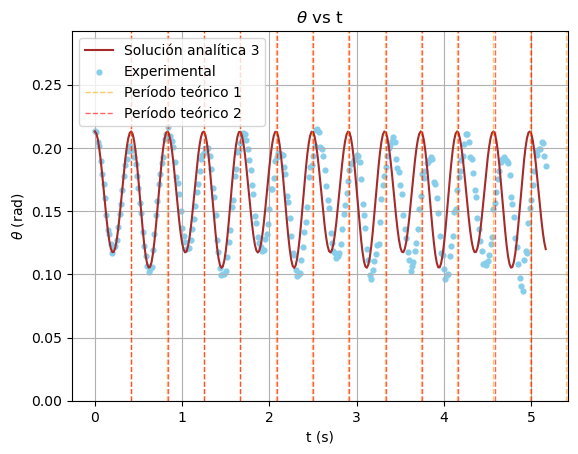

R2 de theta1: 0.883994402465202
R2 de theta2: 0.8853400427750555
R2 de theta3: 0.9163308049157085


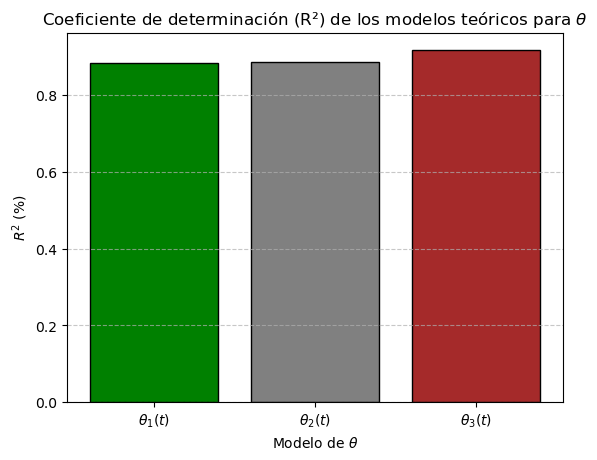

Ángulo pequeño: False
Variación pequeña: 0.4498, False


In [35]:
df=pd.read_excel(file_path3)

omega=2*(g/l)**(1/2)
i=1
#======================================Determinación de u0 e inserción a la base de datos df======================================
df.loc[0, 'ω']=determine_u0(df['ω'])[i]
print(f"Rapidez angular azimutal inicial: {float(df.loc[0, 'ω'])} rad/s")
print(f"Sqrt(g/l * sec theta0)={np.sqrt(g/l*1/np.cos(float(df.loc[0, 'theta'])))} rad/s")

#==========================================================Solución analítica 1==========================================================
vec1=aSol1(df, omega, i)
A=vec1[0]
B=vec1[1]
df['theta1']=vec1[2]


#==========================================================Solución analítica 2==========================================================
vec2=aSol2(df, omega, i)
C=vec2[0]
D=vec2[1]
df['theta2']=vec2[2]

# Período
tau2 = period(df)

#Graficación
graph1(df, tau2)

#==========================================================Solución analítica 3==========================================================
# Solución analítica 3
aSol3(df, tau2, -C, D, -A, B)

r2_bargraph(df, True)

print("Ángulo pequeño: " + str(float(df['theta'].max())<=np.pi/15))

# Se usan parámetros de la solución analítica 2 porque incluye a los 2 ángulos extremos de la oscilación
# 2C = theta0-thetaf
# C+D = theta0
print("Variación pequeña: " + "{:.4g}".format(np.abs(2*C / (C+D))) + ", " + str(round(np.abs(2*C / (C+D)), 3)<=0.40))

$\phi(t)$

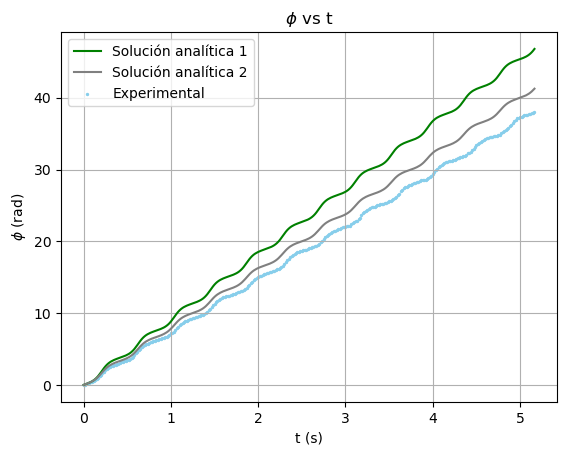

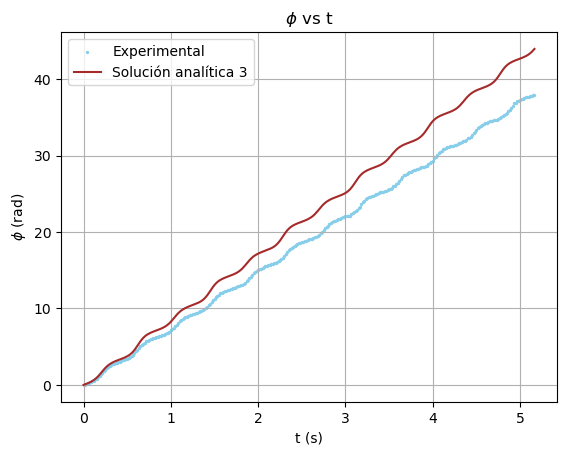

In [36]:
theta0=df['theta'].iloc[0]
u0=df['ω'].iloc[0]

#==========================================================Solución analítica 1==========================================================
df['phi1']=phiSol1(df)

#==========================================================Solución analítica 2==========================================================
df['phi2']=phiSol2(df)

graph2(df)

#==========================================================Solución analítica 3==========================================================
df['phi3']=phiSol3(df)

graph3(df)

Error de modelos teóricos

MAPE del primer modelo: 19.287060335775546
MAPE del segundo modelo: 18.8679862564094
MAE del primer modelo: 0.02846585045790078
MAE del segundo modelo: 0.02708836856907853
MdAPE del primer modelo: 14.36720744001956
MdAPE del segundo modelo: 13.343716035351846
MdAE del primer modelo: 0.022607911380782414
MdAE del segundo modelo: 0.021698949543321827
MAPE del tercer modelo: 18.424499628875797
MAE del tercer modelo: 0.026944941446458297
MdAPE del tercer modelo: 12.853900743512833
MdAE del tercer modelo: 0.020263627912376486


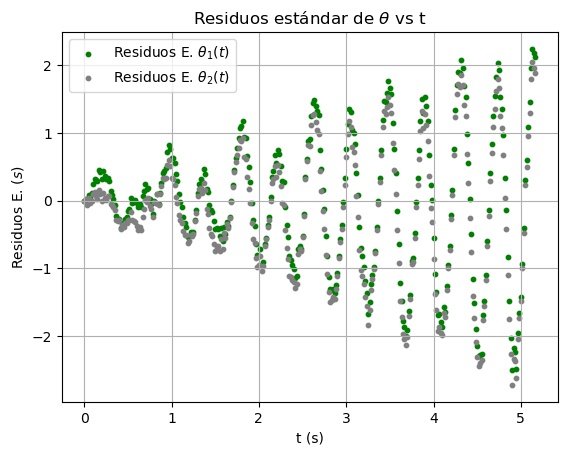

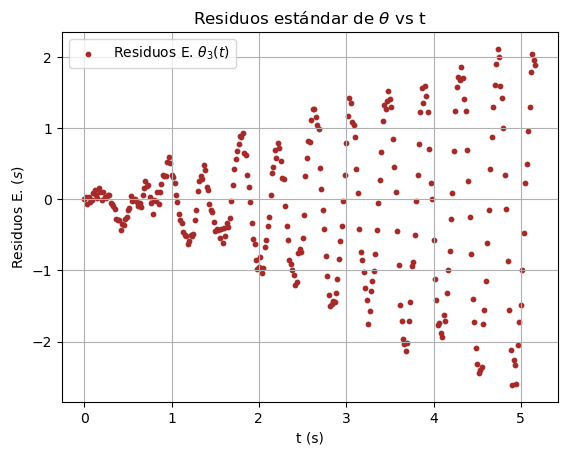

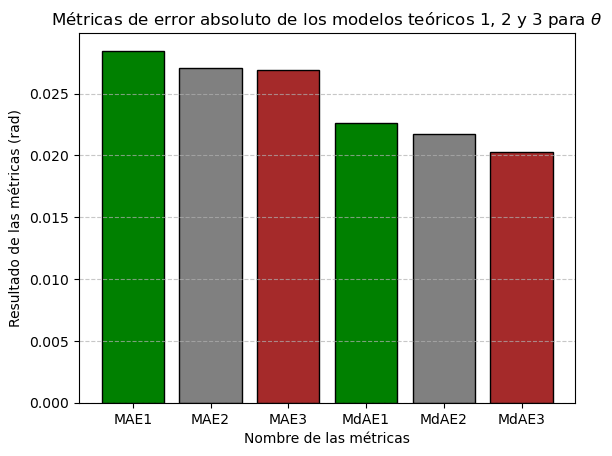

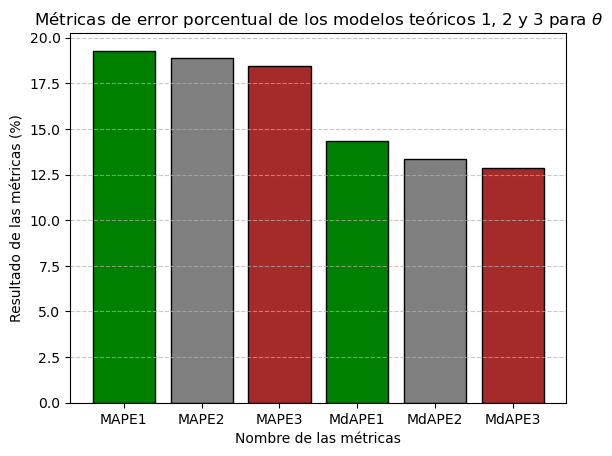

MAPE del primer modelo: 23.356313406412617
MAPE del segundo modelo: 9.090046899807064
MAE del primer modelo: 4.396377037674742
MAE del segundo modelo: 1.603494662711137
MdAPE del primer modelo: 22.653460521372466
MdAPE del segundo modelo: 8.316866391644421
MdAE del primer modelo: 4.1850000721303005
MdAE del segundo modelo: 1.601899148471162
MAPE del tercer modelo: 15.027543862727697
MAE del tercer modelo: 2.8913896068174814
MdAPE del tercer modelo: 14.614093528979902
MdAE del tercer modelo: 2.837801281023804


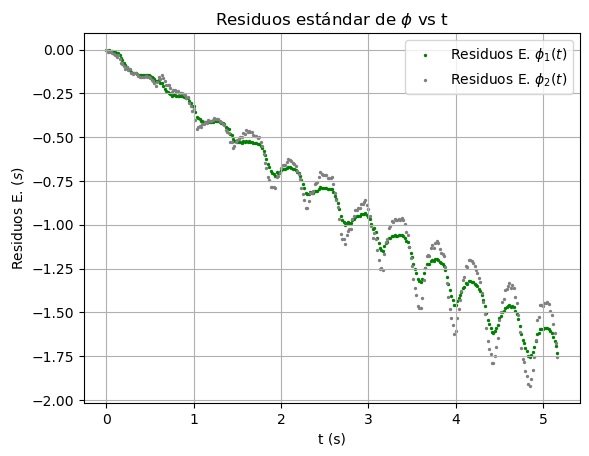

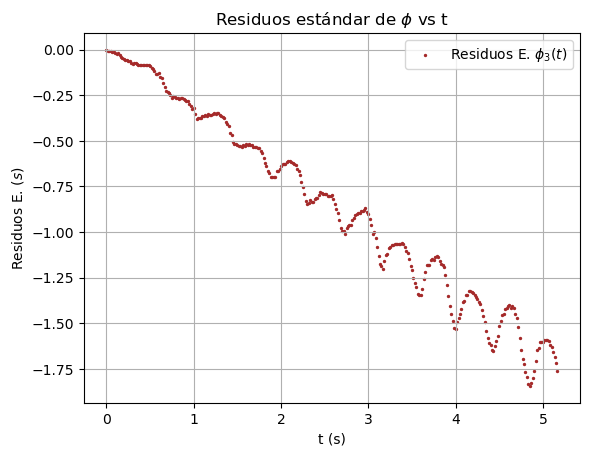

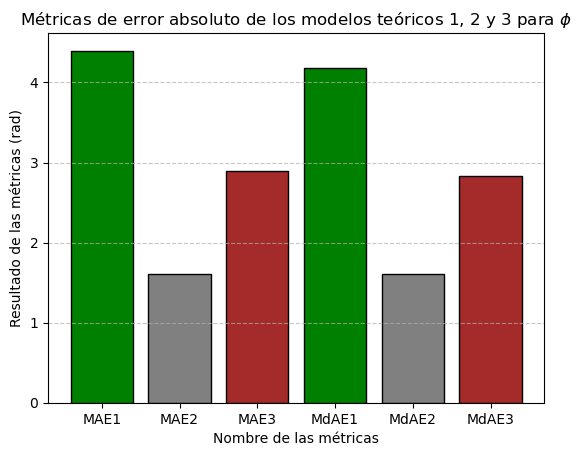

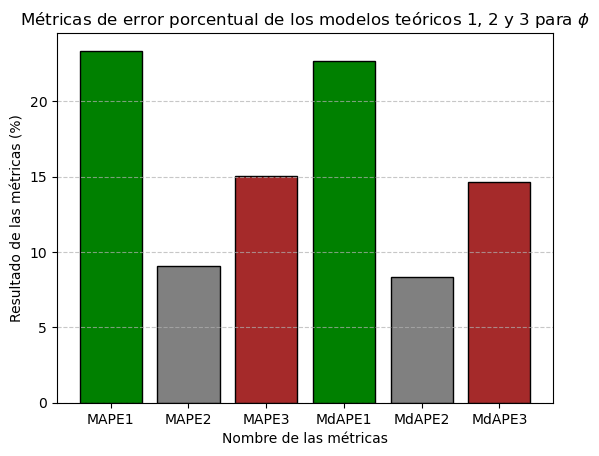

In [37]:
# Error
flag = True
errortheta(df, flag)
errorphi(df, flag)

**Machine Learning**

In [38]:
# Cálculo de residuos
df['resids1']=residuals1(df)
df['resids2']=residuals2(df)
if flag: df['resids3']=residuals3(df)

*Random Forest*

MAPE: 382.26220851001307, MdAPE: 80.88340096135472
R2: 0.6934143365210079


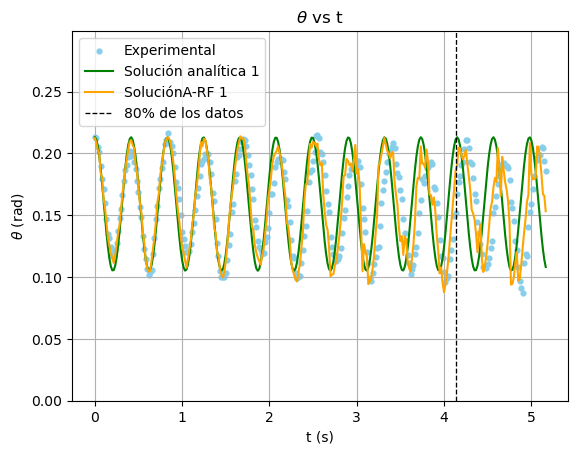

MAPE: 133.7586266922885, MdAPE: 77.99265527016172
R2: 0.7319986380445239


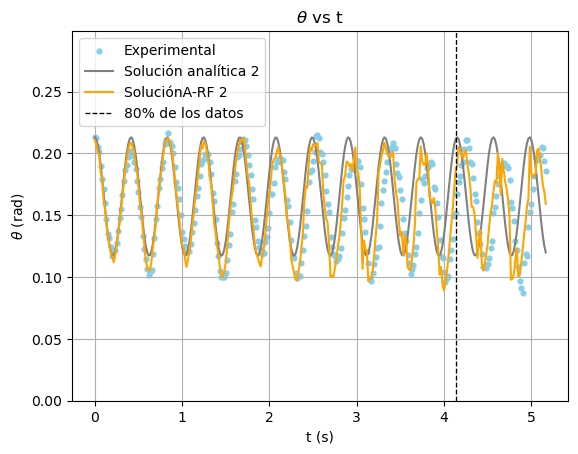

MAPE: 449.06055349126876, MdAPE: 85.35894469698387
R2: 0.7077963420248095


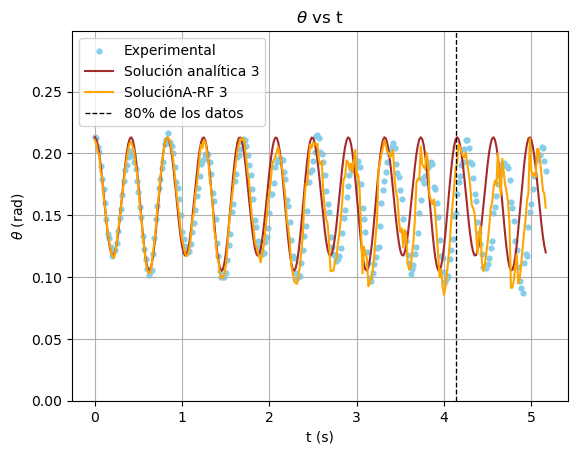

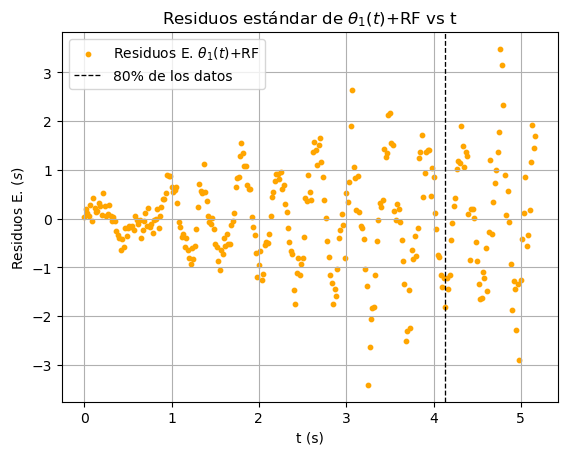

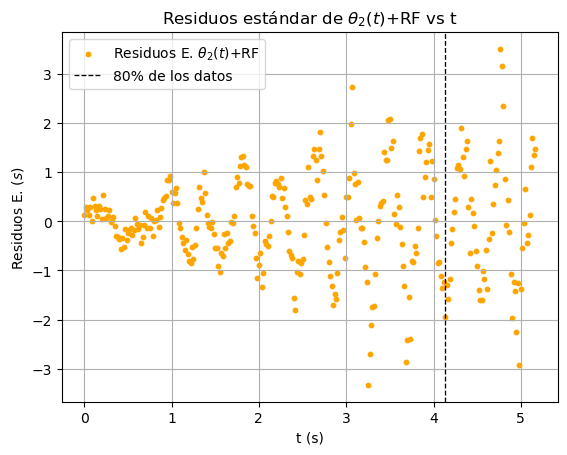

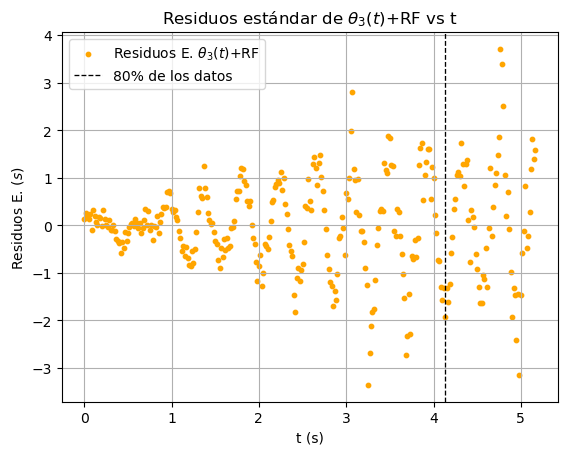

In [39]:
randomForestTotal(df, flag)
residsRF(df, flag)

C:\Users\jmarr\AppData\Local\Temp\ipykernel_876\3292867183.py:34: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  values.append(simps(u0*theta0**2/(df['theta1RF'].iloc[0:i])**2, df['t'].iloc[0:i]))


MdAPE: 19.204120048644825


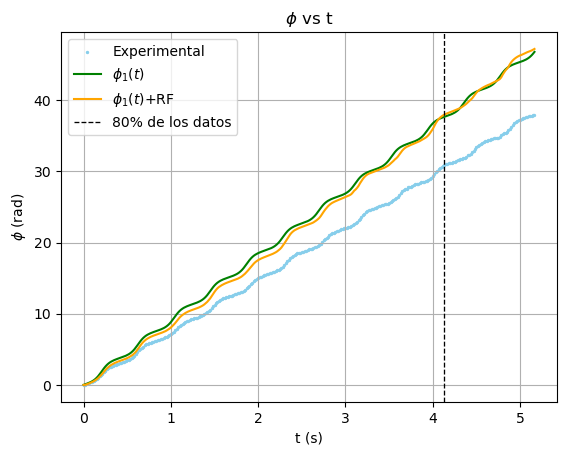

C:\Users\jmarr\AppData\Local\Temp\ipykernel_876\3292867183.py:55: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  values.append(simps(u0*theta0**2/(df['theta2RF'].iloc[0:i])**2, df['t'].iloc[0:i]))


MdAPE: 18.6066455212681


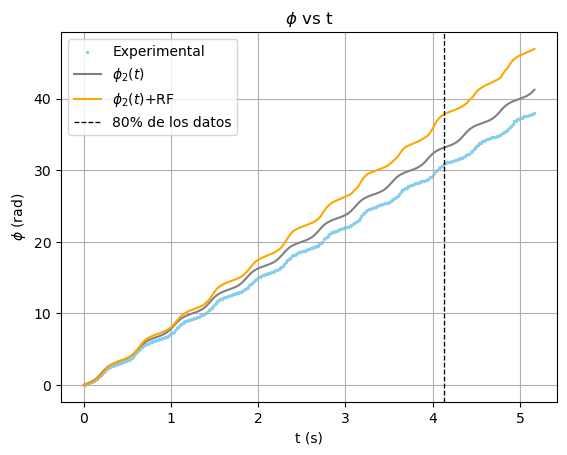

C:\Users\jmarr\AppData\Local\Temp\ipykernel_876\3292867183.py:76: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  values.append(simps(u0*theta0**2/(df['theta3RF'].iloc[0:i])**2, df['t'].iloc[0:i]))


MdAPE: 19.407790628562484


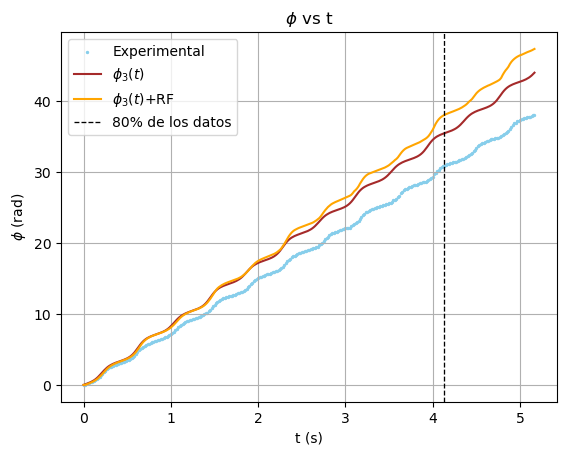

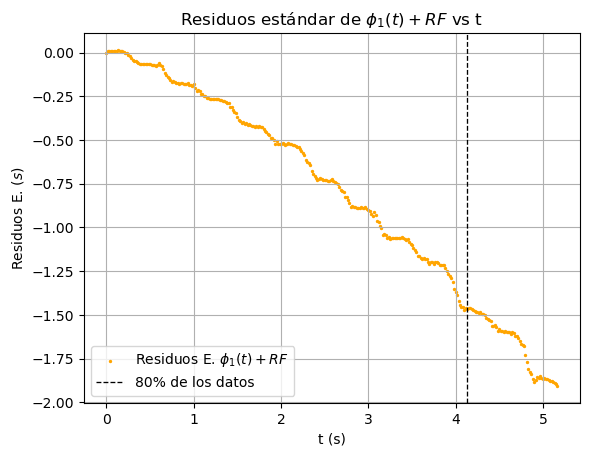

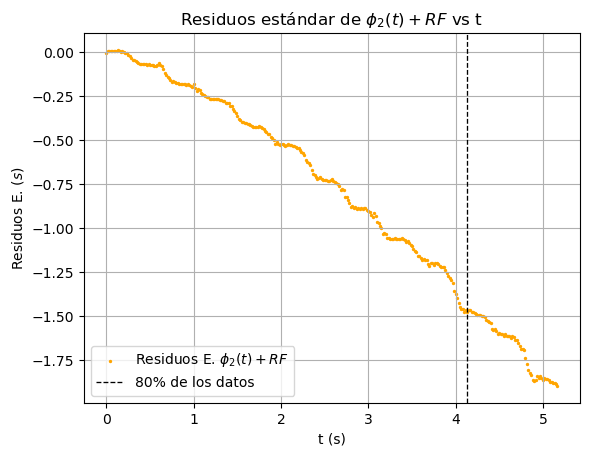

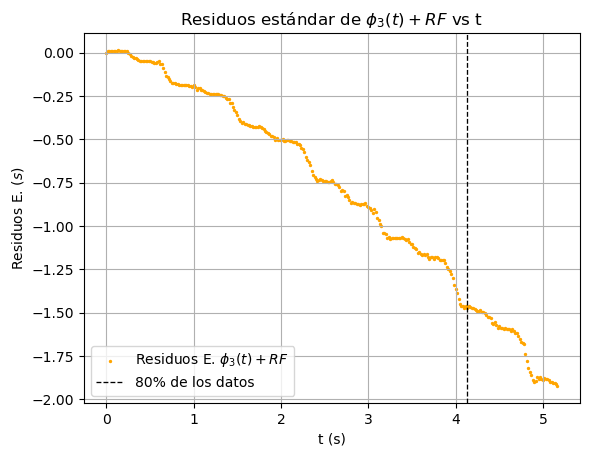

In [40]:
newPhi(df, "RF", flag, u0, theta0)

*XGBoost*

MAPE: 144.1088989350362, MdAPE: 60.78548893514206
R2: 0.8343352362839578


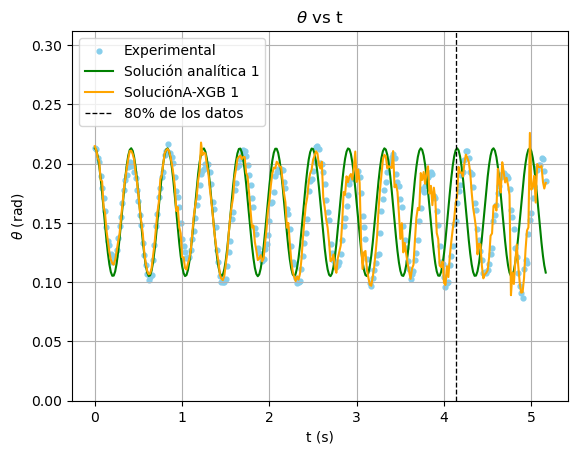

MAPE: 202.63318532601562, MdAPE: 69.21880523489409
R2: 0.8542543862138816


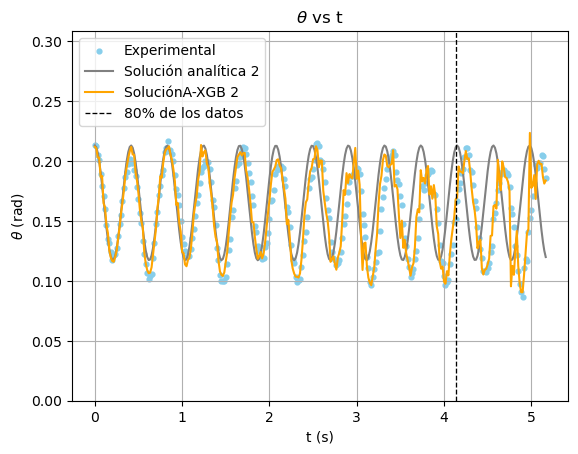

MAPE: 240.99076785680117, MdAPE: 73.69278373653833
R2: 0.8599564139650098


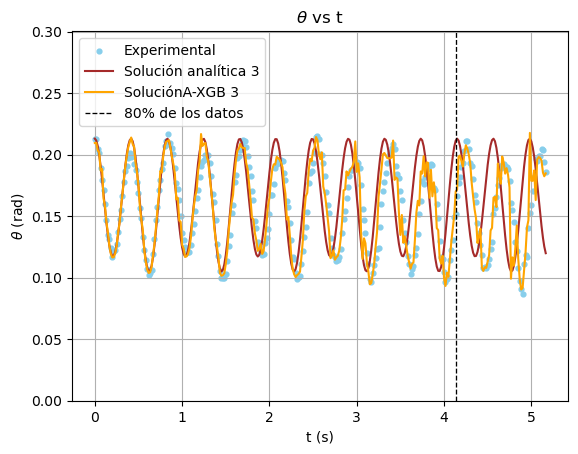

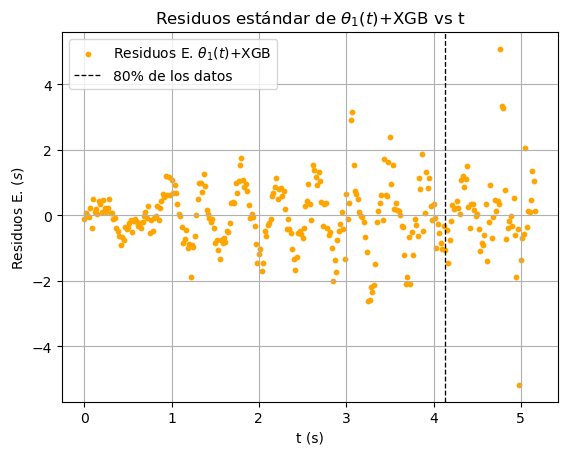

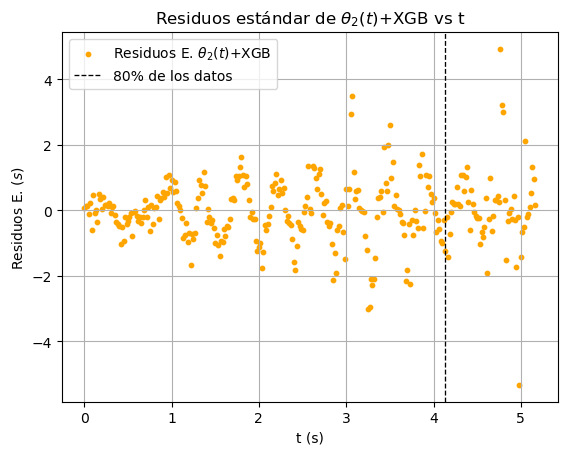

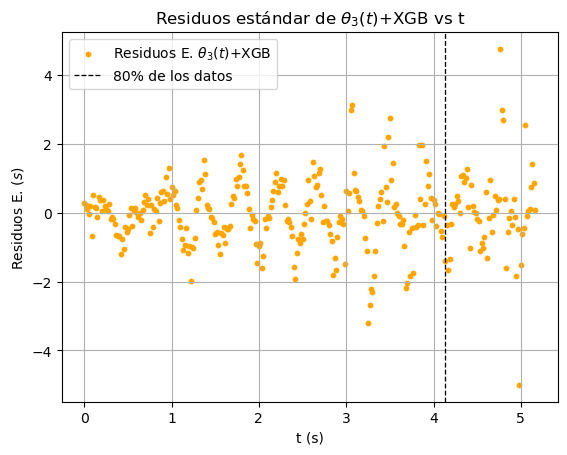

In [41]:
XGBoostTotal(df, flag)
residsXGB(df, flag)

C:\Users\jmarr\AppData\Local\Temp\ipykernel_876\3292867183.py:133: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  values.append(simps(u0*theta0**2/(df['theta1XGB'].iloc[0:i])**2, df['t'].iloc[0:i]))


MdAPE: 16.81907457766048


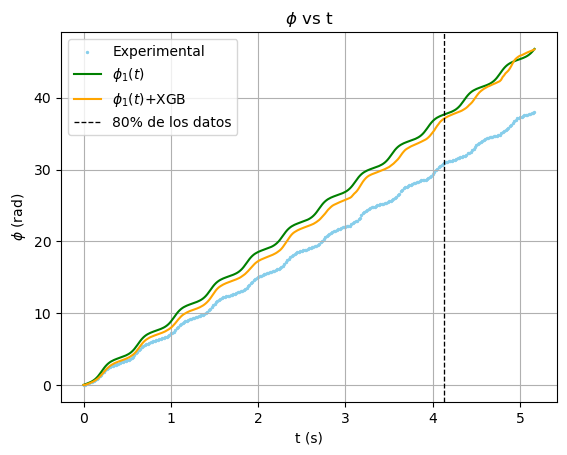

C:\Users\jmarr\AppData\Local\Temp\ipykernel_876\3292867183.py:154: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  values.append(simps(u0*theta0**2/(df['theta2XGB'].iloc[0:i])**2, df['t'].iloc[0:i]))


MdAPE: 16.011905628505264


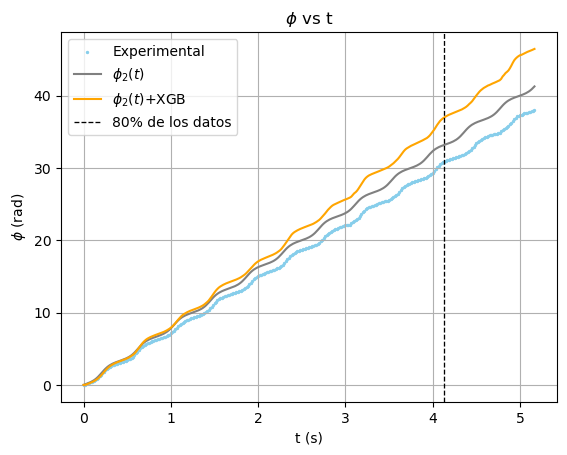

C:\Users\jmarr\AppData\Local\Temp\ipykernel_876\3292867183.py:175: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  values.append(simps(u0*theta0**2/(df['theta3XGB'].iloc[0:i])**2, df['t'].iloc[0:i]))


MdAPE: 16.978620024485952


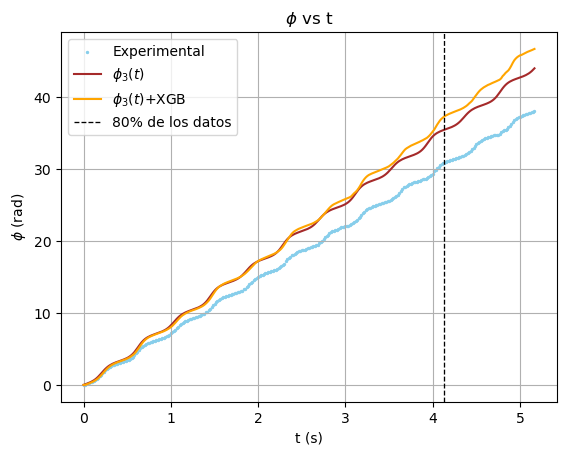

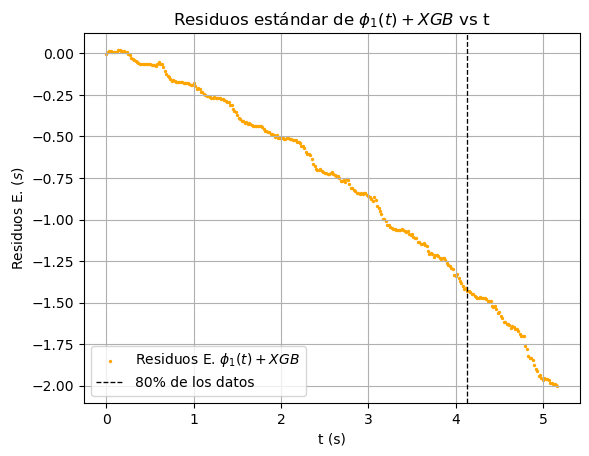

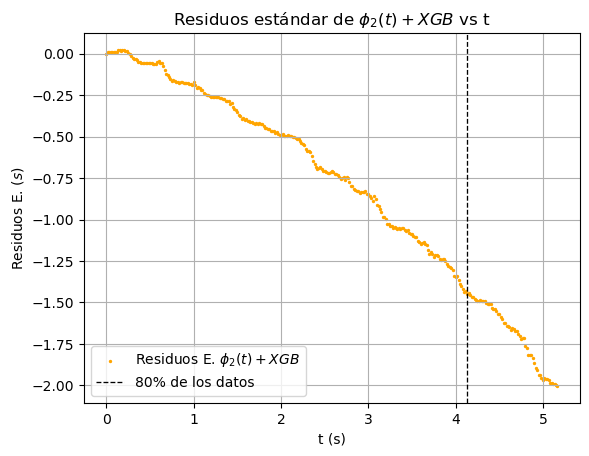

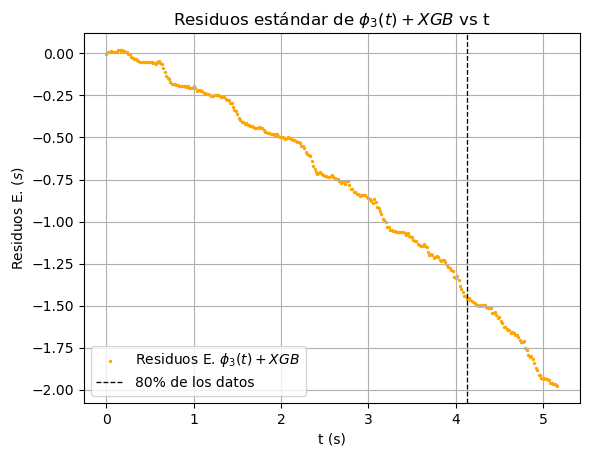

In [42]:
newPhi(df, "XGB", flag, u0, theta0)

*Neural Networks*

Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 2.1492 - mae: 1.1757 - val_loss: 1.0159 - val_mae: 0.7479
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6577 - mae: 1.0744 - val_loss: 1.0120 - val_mae: 0.7575
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6678 - mae: 1.0294 - val_loss: 1.0104 - val_mae: 0.7639
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3628 - mae: 0.9376 - val_loss: 1.0266 - val_mae: 0.7683
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.3981 - mae: 0.9266 - val_loss: 1.0243 - val_mae: 0.7661
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2453 - mae: 0.9017 - val_loss: 1.0296 - val_mae: 0.7692
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2450 - mae: 0.9081 - val_loss: 1.0435 - val_mae: 0.7751
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0225 - mae: 0.8168 - val_loss: 1.0548 - val_mae: 0.7794
Epoch 9/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9769 - mae: 

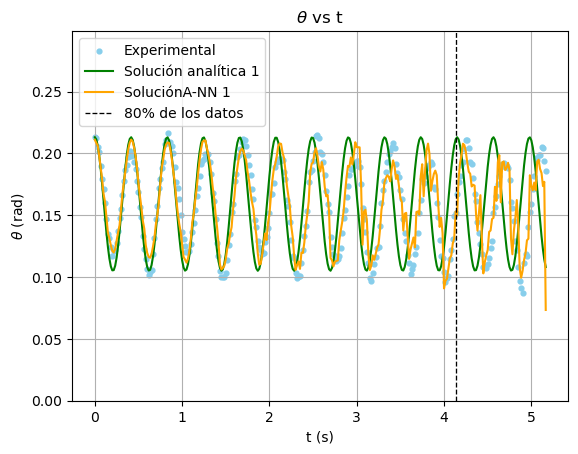

MAPE: 88.69147598649847, MdAPE: 59.917021662404046
R2: 0.8066361262447018


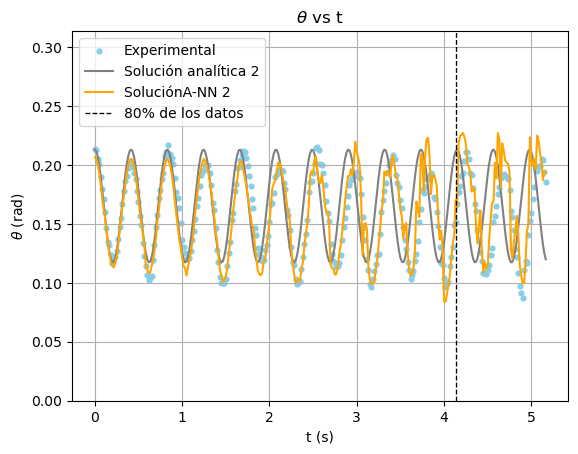

MAPE: 200.12840284316854, MdAPE: 68.4515294315629
R2: 0.564141805935085


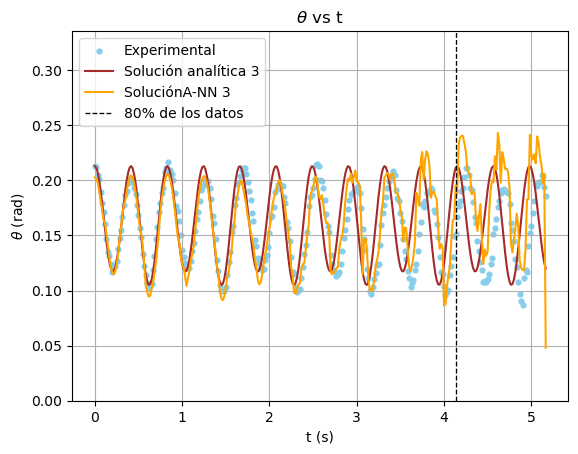

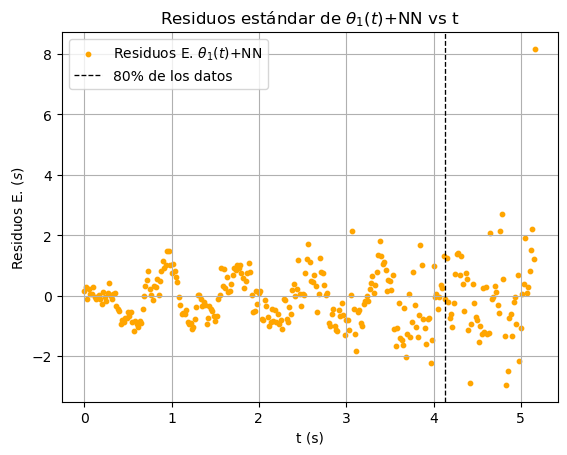

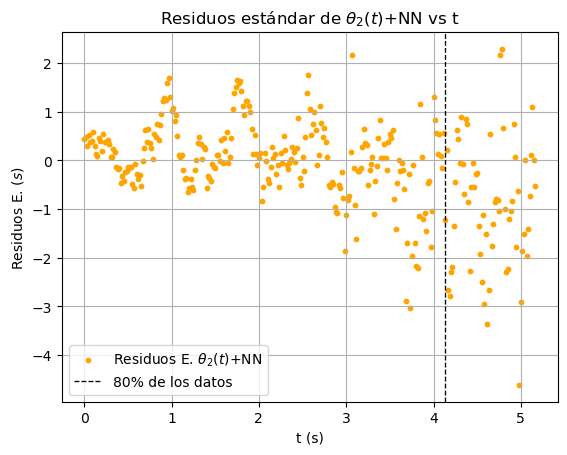

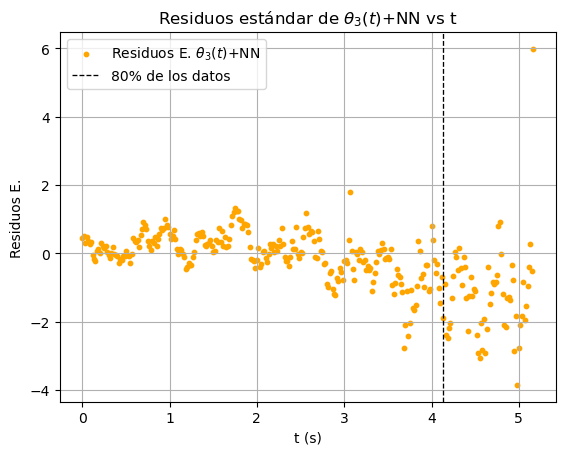

In [43]:
nnTotal(df, flag)
residsNN(df, flag)

C:\Users\jmarr\AppData\Local\Temp\ipykernel_876\3292867183.py:231: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  values.append(simps(u0*theta0**2/(df['theta1NN'].iloc[0:i])**2, df['t'].iloc[0:i]))


MdAPE: 14.114822966641984


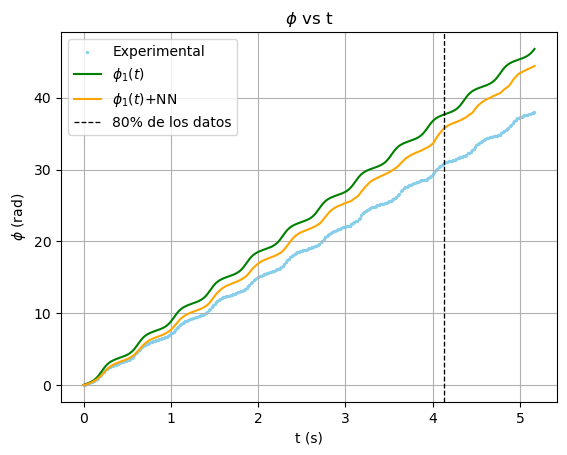

C:\Users\jmarr\AppData\Local\Temp\ipykernel_876\3292867183.py:252: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  values.append(simps(u0*theta0**2/(df['theta2NN'].iloc[0:i])**2, df['t'].iloc[0:i]))


MdAPE: 21.726475163180954


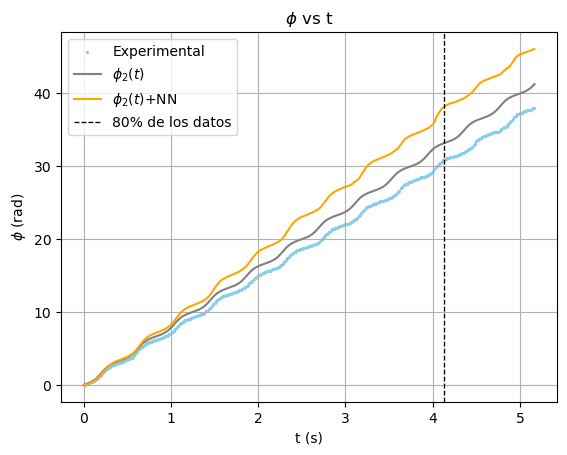

C:\Users\jmarr\AppData\Local\Temp\ipykernel_876\3292867183.py:273: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  values.append(simps(u0*theta0**2/(df['theta3NN'].iloc[0:i])**2, df['t'].iloc[0:i]))


MdAPE: 22.644489379379255


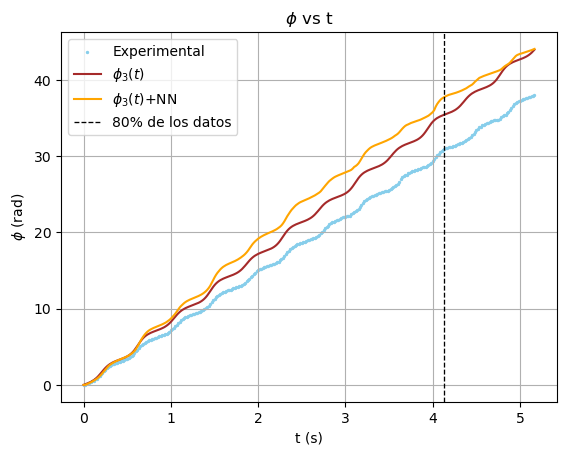

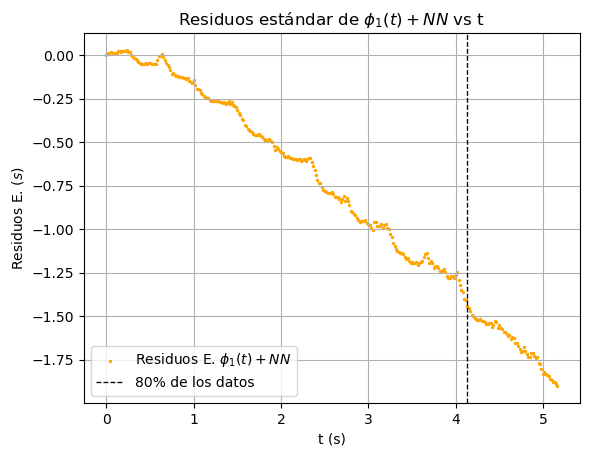

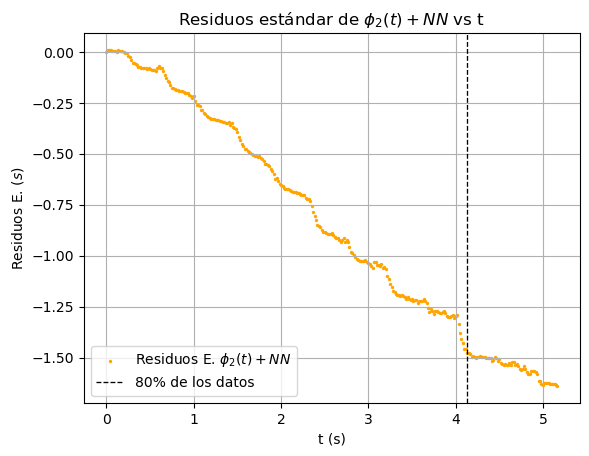

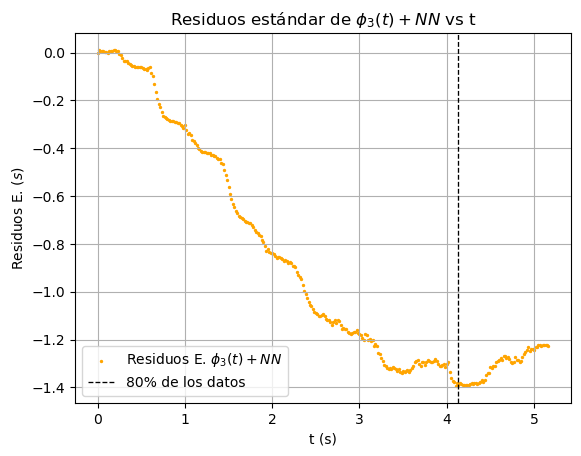

In [44]:
newPhi(df, "NN", flag, u0, theta0)